In [1]:
import csv
from pathlib import Path

import numpy as np
import pandas as pd
from julia import Main

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from scipy.integrate import trapezoid

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.1+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
transition_params = (("Q", 1, 1 / 2, 0), ("Q", 1, 1 / 2, 1))
J_fill = [1]

In [4]:
# Parameters
transition_params = [["R", 0, 1.5, 1.0], ["P", 2, 1.5, 1.0]]
J_fill = [0, 2]


In [5]:
trans = []
for t, J, F1, F in transition_params:
    trans.append(
        transitions.OpticalTransition(
            getattr(transitions.OpticalTransitionType, t), J_ground=J, F1=F1, F=F
        )
    )

In [6]:
polarizations = [[couplings.polarization_σm, couplings.polarization_σp]] * len(trans)

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [7]:
Jmax = max([trans.excited_main.largest.J for trans in transition_selectors]) + 2

In [8]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    Jmax_X=Jmax,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [9]:
odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0*variable_on_off(t, ton0, toff0, phase0)",
    Ωl0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    Pσm0="P0>0",
    Pσp0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Ω1="Ωl1*variable_on_off(t, ton1, toff1, phase1)",
    Ωl1=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # on/off parameters
    ton0=1e-6,
    toff0=1e-6,
    ton1=1e-6,
    toff1=1e-6,
    phase0=0.0,
    phase1=np.pi,
)

In [10]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [11]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

|B, J = 1, F₁ = 3/2, F = 1>
states                                 
|X, J = 0>                     0.484129
|X, J = 2>                     0.515871

In [12]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

|B, J = 1, F₁ = 3/2, F = 1>
states                                                  
|X, J = 0, F₁ = 1/2, F = 0>                     0.336756
|X, J = 0, F₁ = 1/2, F = 1>                     0.147373
|X, J = 2, F₁ = 3/2, F = 1>                     0.100763
|X, J = 2, F₁ = 3/2, F = 2>                     0.026135
|X, J = 2, F₁ = 5/2, F = 2>                     0.388973

In [13]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J4 = states.QuantumSelector(
    J=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J5 = states.QuantumSelector(
    J=5, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [14]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=J_fill, electronic=states.ElectronicState.X), obe_system.QN
)

In [15]:
odepars.ton0 = 2e-6
odepars.ton1 = 2e-6
odepars.toff0 = 1e-6
odepars.toff1 = 1e-6
odepars.phase0 = 0.0
odepars.phase1 = np.pi
odepars.Ωl0 = hamiltonian.Γ
odepars.Ωl1 = hamiltonian.Γ

In [16]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [17]:
results = lindblad_julia.do_simulation_single(problem, config=config)

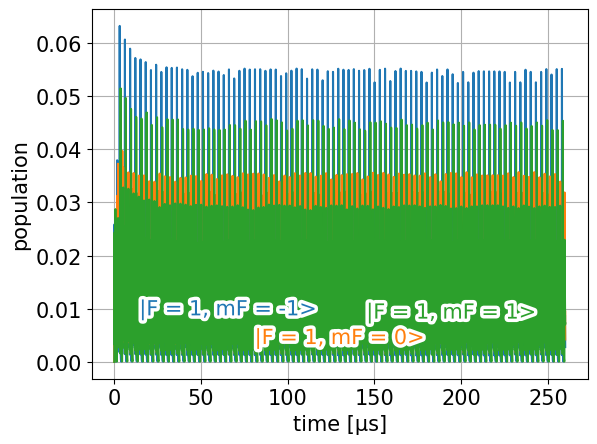

In [18]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

# photons = 78.5
rate = 3.02e+05 Hz


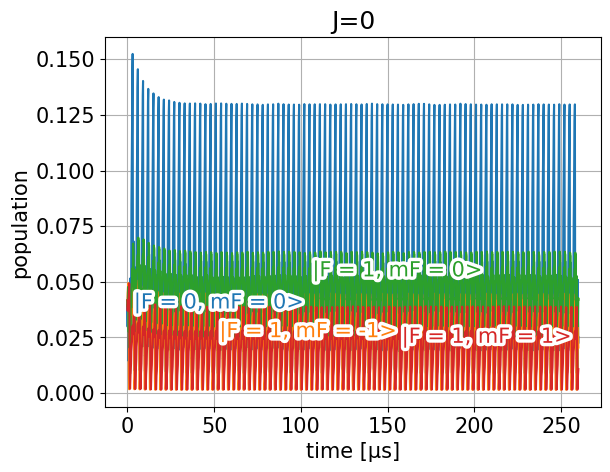

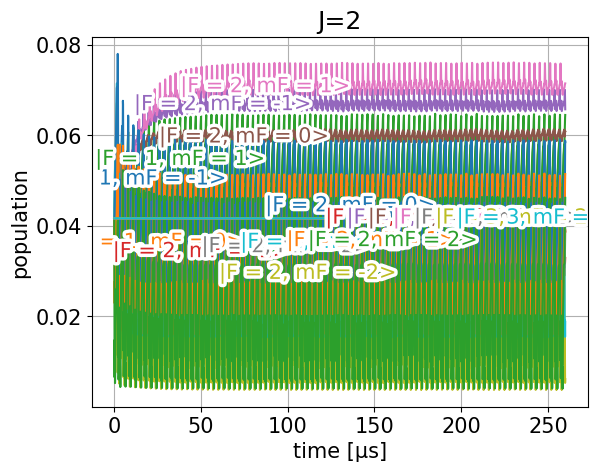

In [19]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} Hz")

# Bayesian Optimization

In [20]:
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.plot.trace import optimization_trace_single_method

from ax import optimize

In [21]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [22]:
import copy
from julia import Main


def optimize_function(p):
    odepars_opt = copy.copy(odepars)
    for key, value in p.items():
        if "Ω" in key:
            value *= hamiltonian.Γ
        setattr(odepars_opt, key, value)

    problem = lindblad_julia.OBEProblem(odepars_opt, ρ, tspan=(0, 200e-6))
    config = lindblad_julia.OBEProblemConfig(
        saveat=1e-6,
        reltol=1e-3,
        abstol=1e-7,
        save_everystep=True,
        callback=None,
        save_idxs=save_idxs_excited,
    )
    lindblad_julia.setup_problem(
        problem.odepars, problem.tspan, problem.ρ, problem.name
    )
    lindblad_julia.solve_problem(problem, config)

    y = np.array(Main.eval("sol.u"))
    t = np.array(Main.eval("sol.t"))

    return trapezoid(y.sum(axis=1).real, x=t) * hamiltonian.Γ

In [23]:
def rescale_parameters(p: dict[str, float]):
    for par in p.keys():
        if "Ω" in par:
            p[par] *= hamiltonian.Γ
        if "ω" in par:
            p[par] *= hamiltonian.Γ
        if "t" in par:
            p[par] /= 1e-6
    return p

In [24]:
odepars.φ0 = 0.0
odepars.phase0 = 0.0
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
    callback=None,
    save_idxs=save_idxs_excited,
)
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)

In [25]:
D = 2.6675506e-30
intensity = 2 / (25.4e-3 * 2 * 25.4e-3)  # 2W over 1x2"

rabi0 = (
    utils.rabi.intensity_to_rabi(
        intensity, np.abs(obe_system.couplings[0].main_coupling), D
    )
    / hamiltonian.Γ
)
rabi1 = (
    utils.rabi.intensity_to_rabi(
        intensity, np.abs(obe_system.couplings[1].main_coupling.real), D
    )
    / hamiltonian.Γ
)

In [26]:
def optimize_function_parallel(p: dict[int, dict[str, float]]):
    p = copy.deepcopy(p)
    for key, pardict in p.items():
        p[key] = rescale_parameters(pardict)

    parameter_names = list(p[list(p.keys())[0]].keys())
    parameters = np.zeros([len(parameter_names), len(p)])
    for idx, pardict in enumerate(p.values()):
        for idp, par in enumerate(parameter_names):
            parameters[idp, idx] = pardict[par]

    ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
        method="Tsit5()",
        distributed_method="EnsembleDistributed()",
        save_everystep=True,
        save_idxs=save_idxs_excited,
        callback=None,
        reltol=1e-3,
        abstol=1e-7,
        saveat=1e-6,
    )

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem,
        parameters=parameter_names,
        scan_values=parameters,
        output_func=output_function,
        zipped=True,
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

    results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

    return [(idt, {"nphotons": r}) for idt, r in zip(p.keys(), results_scan.results)]

In [27]:
ax_client = AxClient()

ax_client.create_experiment(
    name="photon scattering",
    parameters=[
        {
            "name": "Ωl0",
            "type": "range",
            "bounds": [0.0, rabi0],
        },
        {
            "name": "Ωl1",
            "type": "range",
            "bounds": [0.0, rabi1],
        },
        {
            "name": "phase1",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "ω0",
            "type": "range",
            "bounds": [0.0, 2.0],
        },
        {
            "name": "ω1",
            "type": "range",
            "bounds": [0.0, 2.0],
        },
        {
            "name": "φ1",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "ton0",
            "type": "range",
            "bounds": [0.0, 40.0],
        },
        {
            "name": "toff0",
            "type": "range",
            "bounds": [0.0, 40.0],
        },
        {
            "name": "ton1",
            "type": "range",
            "bounds": [0.0, 40.0],
        },
        {
            "name": "toff1",
            "type": "range",
            "bounds": [0.0, 40.0],
        },
    ],
    objectives={"nphotons": ObjectiveProperties(minimize=False)},
)

[INFO 10-30 16:18:43] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Ωl0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Ωl1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter phase1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ω0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ω1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter φ1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ton0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter toff0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ton1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter toff1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 10-30 16:18:43] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Ωl0', parameter_type=FLOAT, range=[0.0, 0.7570485627851833]), RangeParameter(name='Ωl1', parameter_type=FLOAT, range=[0.0, 0.5500309626417307]), RangeParameter(name='phase1', parameter_type=FLOAT, range=[0.0, 6.283185307179586]), RangeParameter(name='ω0', parameter_type=FLOAT, range=[0.0, 2.0]), RangeParameter(name='ω1', parameter_type=FLOAT, range=[0.0, 2.0]), RangeParameter(name='φ1', parameter_type=FLOAT, range=[0.0, 6.283185307179586]), RangeParameter(name='ton0', parameter_type=FLOAT, range=[0.0, 40.0]), RangeParameter(name='toff0', parameter_type=FLOAT, range=[0.0, 40.0]), RangeParameter(name='ton1', parameter_type=FLOAT, range=[0.0, 40.0]), RangeParameter(name='toff1', parameter_type=FLOAT, range=[0.0, 40.0])], parameter_constraints=[]).


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=10 num_trials=None use_batch_trials=False


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=20


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=20


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: `verbose`, `disable_progbar`, and `jit_compile` are not yet supported when using `choose_generation_strategy` with ModularBoTorchModel, dropping these arguments.


[INFO 10-30 16:18:43] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 20 trials, BoTorch for subsequent trials]). Iterations after 20 will take longer to generate due to model-fitting.


In [28]:
ntrials = 0
while ntrials < 200:
    trials, _ = ax_client.get_next_trials(25)
    res = optimize_function_parallel(trials)
    for trial_index, data in res:
        ax_client.complete_trial(trial_index=trial_index, raw_data=data)
    ntrials += len(trials)

c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 0 with parameters {'Ωl0': 0.276696, 'Ωl1': 0.303017, 'phase1': 2.599737, 'ω0': 0.706389, 'ω1': 0.216311, 'φ1': 4.742339, 'ton0': 16.184564, 'toff0': 22.969751, 'ton1': 28.447044, 'toff1': 29.158578} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 1 with parameters {'Ωl0': 0.582053, 'Ωl1': 0.209817, 'phase1': 5.179127, 'ω0': 1.51413, 'ω1': 1.201925, 'φ1': 0.932422, 'ton0': 39.13659, 'toff0': 16.382244, 'ton1': 18.092112, 'toff1': 18.047765} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 2 with parameters {'Ωl0': 0.399449, 'Ωl1': 0.423447, 'phase1': 1.505306, 'ω0': 0.482035, 'ω1': 1.506493, 'φ1': 3.031758, 'ton0': 7.679452, 'toff0': 3.538939, 'ton1': 8.857969, 'toff1': 9.764455} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 3 with parameters {'Ωl0': 0.089647, 'Ωl1': 0.089654, 'phase1': 3.331478, 'ω0': 1.297569, 'ω1': 0.521377, 'φ1': 3.90892, 'ton0': 26.999306, 'toff0': 37.108912, 'ton1': 39.602879, 'toff1': 38.653588} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 4 with parameters {'Ωl0': 0.12766, 'Ωl1': 0.49132, 'phase1': 5.865981, 'ω0': 1.202126, 'ω1': 0.848316, 'φ1': 5.593678, 'ton0': 4.083821, 'toff0': 8.672479, 'ton1': 3.519993, 'toff1': 14.897544} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 5 with parameters {'Ωl0': 0.527596, 'Ωl1': 0.017217, 'phase1': 2.108467, 'ω0': 0.01937, 'ω1': 1.8671, 'φ1': 0.176197, 'ton0': 21.220257, 'toff0': 31.929899, 'ton1': 33.009393, 'toff1': 23.479156} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 6 with parameters {'Ωl0': 0.71464, 'Ωl1': 0.37104, 'phase1': 4.607378, 'ω0': 1.984588, 'ω1': 1.437052, 'φ1': 2.192651, 'ton0': 11.962978, 'toff0': 27.83656, 'ton1': 23.784444, 'toff1': 34.333114} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 7 with parameters {'Ωl0': 0.310269, 'Ωl1': 0.137764, 'phase1': 0.032291, 'ω0': 0.794038, 'ω1': 0.418761, 'φ1': 4.652928, 'ton0': 32.732884, 'toff0': 11.56152, 'ton1': 14.686166, 'toff1': 2.914588} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 8 with parameters {'Ωl0': 0.337306, 'Ωl1': 0.459197, 'phase1': 4.290974, 'ω0': 0.230649, 'ω1': 1.08775, 'φ1': 3.422778, 'ton0': 1.433631, 'toff0': 6.218921, 'ton1': 1.487101, 'toff1': 37.316408} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 9 with parameters {'Ωl0': 0.695827, 'Ωl1': 0.12266, 'phase1': 0.496629, 'ω0': 1.047855, 'ω1': 0.072872, 'φ1': 2.741342, 'ton0': 23.243081, 'toff0': 34.387272, 'ton1': 31.915153, 'toff1': 6.220206} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))


[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 10 with parameters {'Ωl0': 0.498434, 'Ωl1': 0.338708, 'phase1': 6.146343, 'ω0': 0.955943, 'ω1': 0.627921, 'φ1': 1.22209, 'ton0': 14.94024, 'toff0': 25.377508, 'ton1': 21.129879, 'toff1': 16.591986} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 11 with parameters {'Ωl0': 0.147303, 'Ωl1': 0.242881, 'phase1': 1.583531, 'ω0': 1.765431, 'ω1': 1.642305, 'φ1': 5.229268, 'ton0': 30.38314, 'toff0': 14.015841, 'ton1': 10.467871, 'toff1': 25.495805} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 12 with parameters {'Ωl0': 0.013908, 'Ωl1': 0.40418, 'phase1': 0.987129, 'ω0': 1.735851, 'ω1': 1.969693, 'φ1': 4.163662, 'ton0': 18.219595, 'toff0': 20.515321, 'ton1': 26.414176, 'toff1': 1.732467} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 13 with parameters {'Ωl0': 0.467148, 'Ωl1': 0.173379, 'phase1': 3.603355, 'ω0': 0.543631, 'ω1': 0.987986, 'φ1': 1.899207, 'ton0': 36.479076, 'toff0': 18.8411, 'ton1': 16.99784, 'toff1': 30.318846} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 14 with parameters {'Ωl0': 0.657144, 'Ωl1': 0.52425, 'phase1': 3.055781, 'ω0': 1.452451, 'ω1': 0.308418, 'φ1': 0.468878, 'ton0': 5.337032, 'toff0': 1.081456, 'ton1': 6.203449, 'toff1': 22.493299} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 15 with parameters {'Ωl0': 0.211308, 'Ωl1': 0.053042, 'phase1': 4.869673, 'ω0': 0.267947, 'ω1': 1.289627, 'φ1': 6.083715, 'ton0': 29.964361, 'toff0': 39.562275, 'ton1': 35.384532, 'toff1': 11.079772} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 16 with parameters {'Ωl0': 0.226681, 'Ωl1': 0.541494, 'phase1': 0.602306, 'ω0': 1.881588, 'ω1': 0.588695, 'φ1': 1.643308, 'ton0': 37.574384, 'toff0': 1.47022, 'ton1': 30.929674, 'toff1': 23.828769} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 17 with parameters {'Ωl0': 0.63253, 'Ωl1': 0.035796, 'phase1': 3.985496, 'ω0': 0.839419, 'ω1': 1.571866, 'φ1': 4.079017, 'ton0': 17.12186, 'toff0': 37.920994, 'ton1': 0.033312, 'toff1': 12.75212} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 18 with parameters {'Ωl0': 0.444008, 'Ωl1': 0.386969, 'phase1': 1.870169, 'ω0': 1.180126, 'ω1': 1.126909, 'φ1': 6.09396, 'ton0': 26.061451, 'toff0': 22.001553, 'ton1': 11.765394, 'toff1': 4.435088} using model Sobol.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 10-30 16:18:43] ax.service.ax_client: Generated new trial 19 with parameters {'Ωl0': 0.04555, 'Ωl1': 0.190592, 'phase1': 6.058739, 'ω0': 0.098989, 'ω1': 0.143256, 'φ1': 0.701, 'ton0': 9.242398, 'toff0': 18.607386, 'ton1': 22.271627, 'toff1': 33.358417} using model Sobol.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 0 with data: {'nphotons': (11.731459, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 1 with data: {'nphotons': (0.31596, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 2 with data: {'nphotons': (11.801142, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 3 with data: {'nphotons': (0.269093, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 4 with data: {'nphotons': (0.300816, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 5 with data: {'nphotons': (0.508716, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 6 with data: {'nphotons': (0.319272, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 7 with data: {'nphotons': (8.040621, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 8 with data: {'nphotons': (0.325581, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 9 with data: {'nphotons': (6.199439, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 10 with data: {'nphotons': (0.317102, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 11 with data: {'nphotons': (4.320403, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 12 with data: {'nphotons': (1.161566, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 13 with data: {'nphotons': (0.320973, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 14 with data: {'nphotons': (0.316927, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 15 with data: {'nphotons': (0.319962, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 16 with data: {'nphotons': (8.510838, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 17 with data: {'nphotons': (0.319534, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 18 with data: {'nphotons': (11.338117, None)}.


[INFO 10-30 16:18:54] ax.service.ax_client: Completed trial 19 with data: {'nphotons': (0.273442, None)}.


[INFO 10-30 16:18:57] ax.service.ax_client: Generated new trial 20 with parameters {'Ωl0': 0.335517, 'Ωl1': 0.493137, 'phase1': 1.716945, 'ω0': 0.804466, 'ω1': 0.209596, 'φ1': 5.224436, 'ton0': 10.665991, 'toff0': 14.268718, 'ton1': 24.212339, 'toff1': 15.248446} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:19:19] ax.service.ax_client: Generated new trial 21 with parameters {'Ωl0': 0.330925, 'Ωl1': 0.49563, 'phase1': 1.727613, 'ω0': 0.944854, 'ω1': 0.106119, 'φ1': 4.066407, 'ton0': 13.467864, 'toff0': 40.0, 'ton1': 1.700321, 'toff1': 9.365883} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:19:32] ax.service.ax_client: Generated new trial 22 with parameters {'Ωl0': 0.336319, 'Ωl1': 0.501441, 'phase1': 1.695282, 'ω0': 0.231074, 'ω1': 0.575861, 'φ1': 6.243018, 'ton0': 29.0906, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 26.442426} using model BoTorch.


[INFO 10-30 16:19:33] ax.service.ax_client: Completed trial 20 with data: {'nphotons': (12.632666, None)}.


[INFO 10-30 16:19:33] ax.service.ax_client: Completed trial 21 with data: {'nphotons': (0.316857, None)}.


[INFO 10-30 16:19:33] ax.service.ax_client: Completed trial 22 with data: {'nphotons': (12.497568, None)}.


[INFO 10-30 16:19:36] ax.service.ax_client: Generated new trial 23 with parameters {'Ωl0': 0.378678, 'Ωl1': 0.37003, 'phase1': 1.542647, 'ω0': 0.602893, 'ω1': 0.63091, 'φ1': 5.742368, 'ton0': 16.432254, 'toff0': 9.133493, 'ton1': 28.793562, 'toff1': 15.487978} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:19:45] ax.service.ax_client: Generated new trial 24 with parameters {'Ωl0': 0.345392, 'Ωl1': 0.381574, 'phase1': 1.857923, 'ω0': 0.401372, 'ω1': 0.465398, 'φ1': 5.495486, 'ton0': 34.018768, 'toff0': 6.379321, 'ton1': 27.996811, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:19:51] ax.service.ax_client: Generated new trial 25 with parameters {'Ωl0': 0.393295, 'Ωl1': 0.382781, 'phase1': 1.323368, 'ω0': 0.654472, 'ω1': 0.755579, 'φ1': 6.018805, 'ton0': 8.931959, 'toff0': 12.870857, 'ton1': 28.635873, 'toff1': 36.273367} using model BoTorch.


[INFO 10-30 16:19:51] ax.service.ax_client: Completed trial 23 with data: {'nphotons': (11.900309, None)}.


[INFO 10-30 16:19:51] ax.service.ax_client: Completed trial 24 with data: {'nphotons': (12.253204, None)}.


[INFO 10-30 16:19:51] ax.service.ax_client: Completed trial 25 with data: {'nphotons': (11.916391, None)}.


[INFO 10-30 16:19:54] ax.service.ax_client: Generated new trial 26 with parameters {'Ωl0': 0.282746, 'Ωl1': 0.467999, 'phase1': 2.099787, 'ω0': 0.247158, 'ω1': 0.144903, 'φ1': 6.283185, 'ton0': 11.709759, 'toff0': 17.643547, 'ton1': 33.449075, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:00] ax.service.ax_client: Generated new trial 27 with parameters {'Ωl0': 0.696199, 'Ωl1': 0.501721, 'phase1': 0.803573, 'ω0': 0.0, 'ω1': 1.2727, 'φ1': 6.283185, 'ton0': 9.597366, 'toff0': 8.731215, 'ton1': 11.376015, 'toff1': 7.500559} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:05] ax.service.ax_client: Generated new trial 28 with parameters {'Ωl0': 0.051878, 'Ωl1': 0.51659, 'phase1': 2.168189, 'ω0': 0.0, 'ω1': 0.417028, 'φ1': 6.283185, 'ton0': 0.0, 'toff0': 40.0, 'ton1': 31.488593, 'toff1': 33.82648} using model BoTorch.


[INFO 10-30 16:20:06] ax.service.ax_client: Completed trial 26 with data: {'nphotons': (11.753418, None)}.


[INFO 10-30 16:20:06] ax.service.ax_client: Completed trial 27 with data: {'nphotons': (2.972806, None)}.


[INFO 10-30 16:20:06] ax.service.ax_client: Completed trial 28 with data: {'nphotons': (1.116549, None)}.


[INFO 10-30 16:20:10] ax.service.ax_client: Generated new trial 29 with parameters {'Ωl0': 0.346251, 'Ωl1': 0.490813, 'phase1': 1.903697, 'ω0': 1.787841, 'ω1': 0.0, 'φ1': 6.283185, 'ton0': 39.782964, 'toff0': 20.728257, 'ton1': 40.0, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:17] ax.service.ax_client: Generated new trial 30 with parameters {'Ωl0': 0.347224, 'Ωl1': 0.550031, 'phase1': 1.244565, 'ω0': 0.0, 'ω1': 0.0, 'φ1': 4.119199, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 0.668839, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:27] ax.service.ax_client: Generated new trial 31 with parameters {'Ωl0': 0.343502, 'Ωl1': 0.031908, 'phase1': 1.84337, 'ω0': 0.699918, 'ω1': 0.0, 'φ1': 6.283185, 'ton0': 0.0, 'toff0': 20.676878, 'ton1': 0.0, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:20:27] ax.service.ax_client: Completed trial 29 with data: {'nphotons': (1.639259, None)}.


[INFO 10-30 16:20:27] ax.service.ax_client: Completed trial 30 with data: {'nphotons': (0.551422, None)}.


[INFO 10-30 16:20:27] ax.service.ax_client: Completed trial 31 with data: {'nphotons': (0.0, None)}.


[INFO 10-30 16:20:33] ax.service.ax_client: Generated new trial 32 with parameters {'Ωl0': 0.300987, 'Ωl1': 0.550031, 'phase1': 1.500742, 'ω0': 0.76488, 'ω1': 0.84515, 'φ1': 4.654066, 'ton0': 11.931963, 'toff0': 0.0, 'ton1': 24.901705, 'toff1': 35.516144} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:42] ax.service.ax_client: Generated new trial 33 with parameters {'Ωl0': 0.396307, 'Ωl1': 0.550031, 'phase1': 0.935629, 'ω0': 1.212885, 'ω1': 1.610805, 'φ1': 6.268924, 'ton0': 0.0, 'toff0': 4.485755, 'ton1': 13.877072, 'toff1': 7.844702} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:20:53] ax.service.ax_client: Generated new trial 34 with parameters {'Ωl0': 0.297709, 'Ωl1': 0.52726, 'phase1': 1.345009, 'ω0': 0.416325, 'ω1': 0.471581, 'φ1': 0.831801, 'ton0': 20.881638, 'toff0': 0.0, 'ton1': 30.899952, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:20:54] ax.service.ax_client: Completed trial 32 with data: {'nphotons': (12.140437, None)}.


[INFO 10-30 16:20:54] ax.service.ax_client: Completed trial 33 with data: {'nphotons': (1.110692, None)}.


[INFO 10-30 16:20:54] ax.service.ax_client: Completed trial 34 with data: {'nphotons': (12.571148, None)}.


[INFO 10-30 16:21:01] ax.service.ax_client: Generated new trial 35 with parameters {'Ωl0': 0.328751, 'Ωl1': 0.461955, 'phase1': 1.855868, 'ω0': 0.606144, 'ω1': 0.435073, 'φ1': 4.80712, 'ton0': 27.481665, 'toff0': 5.916447, 'ton1': 26.592634, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:08] ax.service.ax_client: Generated new trial 36 with parameters {'Ωl0': 0.364206, 'Ωl1': 0.201228, 'phase1': 1.779661, 'ω0': 0.35693, 'ω1': 1.174242, 'φ1': 2.057621, 'ton0': 30.253716, 'toff0': 14.243217, 'ton1': 8.782354, 'toff1': 20.93765} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:16] ax.service.ax_client: Generated new trial 37 with parameters {'Ωl0': 0.397162, 'Ωl1': 0.550031, 'phase1': 2.059935, 'ω0': 0.380947, 'ω1': 1.405321, 'φ1': 4.607635, 'ton0': 31.470601, 'toff0': 0.502247, 'ton1': 3.192623, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:21:16] ax.service.ax_client: Completed trial 35 with data: {'nphotons': (12.551488, None)}.


[INFO 10-30 16:21:16] ax.service.ax_client: Completed trial 36 with data: {'nphotons': (8.633649, None)}.


[INFO 10-30 16:21:16] ax.service.ax_client: Completed trial 37 with data: {'nphotons': (12.501911, None)}.


[INFO 10-30 16:21:22] ax.service.ax_client: Generated new trial 38 with parameters {'Ωl0': 0.343018, 'Ωl1': 0.474145, 'phase1': 1.632446, 'ω0': 0.583173, 'ω1': 0.250446, 'φ1': 5.161941, 'ton0': 27.744308, 'toff0': 3.894268, 'ton1': 35.572992, 'toff1': 0.043453} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:29] ax.service.ax_client: Generated new trial 39 with parameters {'Ωl0': 0.342886, 'Ωl1': 0.550031, 'phase1': 0.865012, 'ω0': 1.243232, 'ω1': 0.825192, 'φ1': 5.390523, 'ton0': 38.581221, 'toff0': 23.922957, 'ton1': 20.991961, 'toff1': 8.51359} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:36] ax.service.ax_client: Generated new trial 40 with parameters {'Ωl0': 0.341389, 'Ωl1': 0.138342, 'phase1': 1.569733, 'ω0': 0.578216, 'ω1': 0.212169, 'φ1': 6.283185, 'ton0': 0.0, 'toff0': 0.0, 'ton1': 33.766431, 'toff1': 39.778874} using model BoTorch.


[INFO 10-30 16:21:37] ax.service.ax_client: Completed trial 38 with data: {'nphotons': (12.69892, None)}.


[INFO 10-30 16:21:37] ax.service.ax_client: Completed trial 39 with data: {'nphotons': (12.324146, None)}.


[INFO 10-30 16:21:37] ax.service.ax_client: Completed trial 40 with data: {'nphotons': (1.076821, None)}.


[INFO 10-30 16:21:41] ax.service.ax_client: Generated new trial 41 with parameters {'Ωl0': 0.267235, 'Ωl1': 0.506294, 'phase1': 1.49418, 'ω0': 0.67061, 'ω1': 0.702867, 'φ1': 3.239256, 'ton0': 35.289595, 'toff0': 13.597332, 'ton1': 28.172214, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:45] ax.service.ax_client: Generated new trial 42 with parameters {'Ωl0': 0.269953, 'Ωl1': 0.525285, 'phase1': 1.388167, 'ω0': 0.303546, 'ω1': 1.230942, 'φ1': 2.018862, 'ton0': 40.0, 'toff0': 2.049332, 'ton1': 20.11171, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:21:51] ax.service.ax_client: Generated new trial 43 with parameters {'Ωl0': 0.302128, 'Ωl1': 0.550031, 'phase1': 1.989286, 'ω0': 0.638922, 'ω1': 0.588821, 'φ1': 0.102102, 'ton0': 24.161375, 'toff0': 14.623162, 'ton1': 34.94919, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:21:51] ax.service.ax_client: Completed trial 41 with data: {'nphotons': (12.373972, None)}.


[INFO 10-30 16:21:51] ax.service.ax_client: Completed trial 42 with data: {'nphotons': (12.697526, None)}.


[INFO 10-30 16:21:51] ax.service.ax_client: Completed trial 43 with data: {'nphotons': (12.602552, None)}.


[INFO 10-30 16:21:56] ax.service.ax_client: Generated new trial 44 with parameters {'Ωl0': 0.364737, 'Ωl1': 0.437963, 'phase1': 1.210397, 'ω0': 0.431575, 'ω1': 1.270672, 'φ1': 2.790393, 'ton0': 36.826175, 'toff0': 9.060522, 'ton1': 10.241748, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:02] ax.service.ax_client: Generated new trial 45 with parameters {'Ωl0': 0.408966, 'Ωl1': 0.542856, 'phase1': 1.31984, 'ω0': 0.443879, 'ω1': 0.629287, 'φ1': 5.408207, 'ton0': 21.394274, 'toff0': 19.315241, 'ton1': 30.185348, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:08] ax.service.ax_client: Generated new trial 46 with parameters {'Ωl0': 0.34754, 'Ωl1': 0.43228, 'phase1': 1.643423, 'ω0': 0.023287, 'ω1': 1.607419, 'φ1': 6.283185, 'ton0': 37.780057, 'toff0': 0.0, 'ton1': 8.396848, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:22:09] ax.service.ax_client: Completed trial 44 with data: {'nphotons': (12.286511, None)}.


[INFO 10-30 16:22:09] ax.service.ax_client: Completed trial 45 with data: {'nphotons': (12.373287, None)}.


[INFO 10-30 16:22:09] ax.service.ax_client: Completed trial 46 with data: {'nphotons': (9.223079, None)}.


[INFO 10-30 16:22:13] ax.service.ax_client: Generated new trial 47 with parameters {'Ωl0': 0.257436, 'Ωl1': 0.550031, 'phase1': 1.463198, 'ω0': 0.492201, 'ω1': 1.212532, 'φ1': 3.995227, 'ton0': 24.171837, 'toff0': 1.210362, 'ton1': 15.491921, 'toff1': 6.369971} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:18] ax.service.ax_client: Generated new trial 48 with parameters {'Ωl0': 0.363612, 'Ωl1': 0.527431, 'phase1': 1.374747, 'ω0': 0.556855, 'ω1': 1.401624, 'φ1': 0.0, 'ton0': 28.061095, 'toff0': 0.0, 'ton1': 13.130989, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:24] ax.service.ax_client: Generated new trial 49 with parameters {'Ωl0': 0.174259, 'Ωl1': 0.550031, 'phase1': 1.787952, 'ω0': 0.500509, 'ω1': 0.541219, 'φ1': 6.283185, 'ton0': 18.877655, 'toff0': 9.138145, 'ton1': 29.9395, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:22:24] ax.service.ax_client: Completed trial 47 with data: {'nphotons': (12.872363, None)}.


[INFO 10-30 16:22:24] ax.service.ax_client: Completed trial 48 with data: {'nphotons': (12.556471, None)}.


[INFO 10-30 16:22:24] ax.service.ax_client: Completed trial 49 with data: {'nphotons': (11.614862, None)}.


[INFO 10-30 16:22:29] ax.service.ax_client: Generated new trial 50 with parameters {'Ωl0': 0.434834, 'Ωl1': 0.491795, 'phase1': 2.156706, 'ω0': 0.558325, 'ω1': 0.224404, 'φ1': 5.154041, 'ton0': 27.666698, 'toff0': 16.916811, 'ton1': 34.560987, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:34] ax.service.ax_client: Generated new trial 51 with parameters {'Ωl0': 0.448096, 'Ωl1': 0.37047, 'phase1': 0.689832, 'ω0': 1.193958, 'ω1': 0.677707, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 21.159072, 'ton1': 18.494509, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:38] ax.service.ax_client: Generated new trial 52 with parameters {'Ωl0': 0.304142, 'Ωl1': 0.285134, 'phase1': 0.427692, 'ω0': 1.433417, 'ω1': 0.757905, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 26.494442, 'ton1': 16.568867, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:22:39] ax.service.ax_client: Completed trial 50 with data: {'nphotons': (12.421004, None)}.


[INFO 10-30 16:22:39] ax.service.ax_client: Completed trial 51 with data: {'nphotons': (11.523616, None)}.


[INFO 10-30 16:22:39] ax.service.ax_client: Completed trial 52 with data: {'nphotons': (9.973314, None)}.


[INFO 10-30 16:22:45] ax.service.ax_client: Generated new trial 53 with parameters {'Ωl0': 0.367471, 'Ωl1': 0.524019, 'phase1': 1.829856, 'ω0': 0.459369, 'ω1': 1.102805, 'φ1': 0.0, 'ton0': 24.517766, 'toff0': 3.311367, 'ton1': 18.973347, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:51] ax.service.ax_client: Generated new trial 54 with parameters {'Ωl0': 0.367567, 'Ωl1': 0.491564, 'phase1': 1.457187, 'ω0': 0.8758, 'ω1': 0.430086, 'φ1': 6.283185, 'ton0': 12.03333, 'toff0': 22.052865, 'ton1': 32.562484, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:22:58] ax.service.ax_client: Generated new trial 55 with parameters {'Ωl0': 0.27873, 'Ωl1': 0.429446, 'phase1': 1.877212, 'ω0': 0.674115, 'ω1': 1.339535, 'φ1': 0.0, 'ton0': 34.174512, 'toff0': 0.0, 'ton1': 4.239727, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:22:59] ax.service.ax_client: Completed trial 53 with data: {'nphotons': (12.663696, None)}.


[INFO 10-30 16:22:59] ax.service.ax_client: Completed trial 54 with data: {'nphotons': (12.391794, None)}.


[INFO 10-30 16:22:59] ax.service.ax_client: Completed trial 55 with data: {'nphotons': (12.10341, None)}.


[INFO 10-30 16:23:03] ax.service.ax_client: Generated new trial 56 with parameters {'Ωl0': 0.351901, 'Ωl1': 0.475583, 'phase1': 1.257387, 'ω0': 0.823696, 'ω1': 0.743276, 'φ1': 6.283185, 'ton0': 24.151494, 'toff0': 13.427095, 'ton1': 21.786847, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:23:09] ax.service.ax_client: Generated new trial 57 with parameters {'Ωl0': 0.291283, 'Ωl1': 0.50138, 'phase1': 2.869875, 'ω0': 0.672896, 'ω1': 0.0, 'φ1': 0.0, 'ton0': 4.609819, 'toff0': 16.552991, 'ton1': 34.836309, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:23:15] ax.service.ax_client: Generated new trial 58 with parameters {'Ωl0': 0.30553, 'Ωl1': 0.533333, 'phase1': 1.966096, 'ω0': 0.593947, 'ω1': 1.606407, 'φ1': 6.283185, 'ton0': 31.639001, 'toff0': 15.164038, 'ton1': 3.873391, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:23:15] ax.service.ax_client: Completed trial 56 with data: {'nphotons': (12.554358, None)}.


[INFO 10-30 16:23:15] ax.service.ax_client: Completed trial 57 with data: {'nphotons': (1.663454, None)}.


[INFO 10-30 16:23:15] ax.service.ax_client: Completed trial 58 with data: {'nphotons': (0.319404, None)}.


[INFO 10-30 16:23:20] ax.service.ax_client: Generated new trial 59 with parameters {'Ωl0': 0.553948, 'Ωl1': 0.417781, 'phase1': 1.255549, 'ω0': 1.114217, 'ω1': 0.691644, 'φ1': 3.988049, 'ton0': 15.885442, 'toff0': 20.609395, 'ton1': 20.015884, 'toff1': 2.593317} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:23:25] ax.service.ax_client: Generated new trial 60 with parameters {'Ωl0': 0.566364, 'Ωl1': 0.390968, 'phase1': 1.309274, 'ω0': 0.531829, 'ω1': 1.279711, 'φ1': 2.659848, 'ton0': 31.034505, 'toff0': 0.0, 'ton1': 5.533825, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:23:31] ax.service.ax_client: Generated new trial 61 with parameters {'Ωl0': 0.498829, 'Ωl1': 0.481206, 'phase1': 0.710969, 'ω0': 0.835564, 'ω1': 0.775054, 'φ1': 0.266316, 'ton0': 9.066723, 'toff0': 13.54764, 'ton1': 30.860974, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:23:32] ax.service.ax_client: Completed trial 59 with data: {'nphotons': (11.488706, None)}.


[INFO 10-30 16:23:32] ax.service.ax_client: Completed trial 60 with data: {'nphotons': (11.162509, None)}.


[INFO 10-30 16:23:32] ax.service.ax_client: Completed trial 61 with data: {'nphotons': (12.033592, None)}.


[INFO 10-30 16:23:38] ax.service.ax_client: Generated new trial 62 with parameters {'Ωl0': 0.185713, 'Ωl1': 0.525576, 'phase1': 2.016395, 'ω0': 0.800803, 'ω1': 1.506554, 'φ1': 0.0, 'ton0': 13.117247, 'toff0': 0.0, 'ton1': 7.121749, 'toff1': 24.482495} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:23:53] ax.service.ax_client: Generated new trial 63 with parameters {'Ωl0': 0.567574, 'Ωl1': 0.550031, 'phase1': 1.576276, 'ω0': 2.0, 'ω1': 0.216309, 'φ1': 1.869305, 'ton0': 19.554886, 'toff0': 14.315688, 'ton1': 21.944691, 'toff1': 24.021917} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:24:09] ax.service.ax_client: Generated new trial 64 with parameters {'Ωl0': 0.0, 'Ωl1': 0.249129, 'phase1': 1.788748, 'ω0': 0.0, 'ω1': 1.484627, 'φ1': 0.0, 'ton0': 11.483651, 'toff0': 0.0, 'ton1': 14.211661, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:24:09] ax.service.ax_client: Completed trial 62 with data: {'nphotons': (0.31435, None)}.


[INFO 10-30 16:24:09] ax.service.ax_client: Completed trial 63 with data: {'nphotons': (11.563155, None)}.


[INFO 10-30 16:24:09] ax.service.ax_client: Completed trial 64 with data: {'nphotons': (0.0, None)}.


[INFO 10-30 16:24:14] ax.service.ax_client: Generated new trial 65 with parameters {'Ωl0': 0.432846, 'Ωl1': 0.550031, 'phase1': 1.026745, 'ω0': 0.958596, 'ω1': 0.59767, 'φ1': 0.173502, 'ton0': 18.183978, 'toff0': 17.880907, 'ton1': 22.367212, 'toff1': 34.234919} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:24:21] ax.service.ax_client: Generated new trial 66 with parameters {'Ωl0': 0.390409, 'Ωl1': 0.550031, 'phase1': 0.819262, 'ω0': 1.132595, 'ω1': 1.197953, 'φ1': 0.0, 'ton0': 33.783245, 'toff0': 0.0, 'ton1': 14.406837, 'toff1': 14.343819} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:24:27] ax.service.ax_client: Generated new trial 67 with parameters {'Ωl0': 0.280288, 'Ωl1': 0.550031, 'phase1': 1.940957, 'ω0': 0.0, 'ω1': 0.108176, 'φ1': 6.283185, 'ton0': 26.95373, 'toff0': 20.12962, 'ton1': 34.35899, 'toff1': 15.96059} using model BoTorch.


[INFO 10-30 16:24:28] ax.service.ax_client: Completed trial 65 with data: {'nphotons': (12.326321, None)}.


[INFO 10-30 16:24:28] ax.service.ax_client: Completed trial 66 with data: {'nphotons': (11.495219, None)}.


[INFO 10-30 16:24:28] ax.service.ax_client: Completed trial 67 with data: {'nphotons': (4.067851, None)}.


[INFO 10-30 16:24:37] ax.service.ax_client: Generated new trial 68 with parameters {'Ωl0': 0.452127, 'Ωl1': 0.408232, 'phase1': 1.834532, 'ω0': 0.0, 'ω1': 1.391023, 'φ1': 5.350607, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 9.805892, 'toff1': 27.955507} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:24:49] ax.service.ax_client: Generated new trial 69 with parameters {'Ωl0': 0.430495, 'Ωl1': 0.414349, 'phase1': 1.627872, 'ω0': 0.0, 'ω1': 0.274088, 'φ1': 0.0, 'ton0': 0.0, 'toff0': 15.575385, 'ton1': 40.0, 'toff1': 33.127723} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:24:59] ax.service.ax_client: Generated new trial 70 with parameters {'Ωl0': 0.461252, 'Ωl1': 0.395263, 'phase1': 1.917442, 'ω0': 1.991918, 'ω1': 1.393419, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 31.861335} using model BoTorch.


[INFO 10-30 16:25:00] ax.service.ax_client: Completed trial 68 with data: {'nphotons': (0.126666, None)}.


[INFO 10-30 16:25:00] ax.service.ax_client: Completed trial 69 with data: {'nphotons': (1.11852, None)}.


[INFO 10-30 16:25:00] ax.service.ax_client: Completed trial 70 with data: {'nphotons': (9.82146, None)}.


[INFO 10-30 16:25:07] ax.service.ax_client: Generated new trial 71 with parameters {'Ωl0': 0.397394, 'Ωl1': 0.504776, 'phase1': 2.061246, 'ω0': 0.877944, 'ω1': 0.867137, 'φ1': 3.692935, 'ton0': 29.415362, 'toff0': 1.146344, 'ton1': 25.766731, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:16] ax.service.ax_client: Generated new trial 72 with parameters {'Ωl0': 0.301474, 'Ωl1': 0.28566, 'phase1': 0.548557, 'ω0': 1.148831, 'ω1': 1.369417, 'φ1': 1.512727, 'ton0': 39.231091, 'toff0': 11.902408, 'ton1': 34.032686, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:26] ax.service.ax_client: Generated new trial 73 with parameters {'Ωl0': 0.314971, 'Ωl1': 0.550031, 'phase1': 1.187204, 'ω0': 1.331986, 'ω1': 0.102989, 'φ1': 0.0, 'ton0': 14.356986, 'toff0': 10.458185, 'ton1': 40.0, 'toff1': 25.095483} using model BoTorch.


[INFO 10-30 16:25:27] ax.service.ax_client: Completed trial 71 with data: {'nphotons': (12.29604, None)}.


[INFO 10-30 16:25:27] ax.service.ax_client: Completed trial 72 with data: {'nphotons': (8.978345, None)}.


[INFO 10-30 16:25:27] ax.service.ax_client: Completed trial 73 with data: {'nphotons': (10.463835, None)}.


[INFO 10-30 16:25:30] ax.service.ax_client: Generated new trial 74 with parameters {'Ωl0': 0.336466, 'Ωl1': 0.550031, 'phase1': 1.646814, 'ω0': 0.65198, 'ω1': 0.52718, 'φ1': 3.9765, 'ton0': 19.872375, 'toff0': 11.21562, 'ton1': 35.909626, 'toff1': 27.876024} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:35] ax.service.ax_client: Generated new trial 75 with parameters {'Ωl0': 0.507184, 'Ωl1': 0.470977, 'phase1': 0.717424, 'ω0': 1.604252, 'ω1': 0.868664, 'φ1': 3.618863, 'ton0': 30.793365, 'toff0': 15.520821, 'ton1': 22.996707, 'toff1': 25.376725} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:44] ax.service.ax_client: Generated new trial 76 with parameters {'Ωl0': 0.438968, 'Ωl1': 0.550031, 'phase1': 0.507256, 'ω0': 0.496359, 'ω1': 1.41697, 'φ1': 1.439599, 'ton0': 18.612199, 'toff0': 0.0, 'ton1': 23.834845, 'toff1': 31.609922} using model BoTorch.


[INFO 10-30 16:25:45] ax.service.ax_client: Completed trial 74 with data: {'nphotons': (12.543013, None)}.


[INFO 10-30 16:25:45] ax.service.ax_client: Completed trial 75 with data: {'nphotons': (11.596545, None)}.


[INFO 10-30 16:25:45] ax.service.ax_client: Completed trial 76 with data: {'nphotons': (12.403403, None)}.


[INFO 10-30 16:25:48] ax.service.ax_client: Generated new trial 77 with parameters {'Ωl0': 0.424179, 'Ωl1': 0.48187, 'phase1': 1.029042, 'ω0': 0.544795, 'ω1': 0.902548, 'φ1': 0.193017, 'ton0': 32.74663, 'toff0': 7.404899, 'ton1': 26.152558, 'toff1': 20.632398} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:54] ax.service.ax_client: Generated new trial 78 with parameters {'Ωl0': 0.579393, 'Ωl1': 0.439972, 'phase1': 0.606523, 'ω0': 0.972667, 'ω1': 0.629076, 'φ1': 0.872479, 'ton0': 24.633964, 'toff0': 6.463529, 'ton1': 27.621672, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:25:59] ax.service.ax_client: Generated new trial 79 with parameters {'Ωl0': 0.441615, 'Ωl1': 0.550003, 'phase1': 1.894579, 'ω0': 0.714806, 'ω1': 1.228225, 'φ1': 5.707186, 'ton0': 33.829337, 'toff0': 7.975655, 'ton1': 30.044597, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:25:59] ax.service.ax_client: Completed trial 77 with data: {'nphotons': (12.366849, None)}.


[INFO 10-30 16:25:59] ax.service.ax_client: Completed trial 78 with data: {'nphotons': (11.552132, None)}.


[INFO 10-30 16:25:59] ax.service.ax_client: Completed trial 79 with data: {'nphotons': (12.361915, None)}.


[INFO 10-30 16:26:06] ax.service.ax_client: Generated new trial 80 with parameters {'Ωl0': 0.278333, 'Ωl1': 0.550031, 'phase1': 1.215885, 'ω0': 0.344541, 'ω1': 1.125436, 'φ1': 6.092017, 'ton0': 31.292038, 'toff0': 0.0, 'ton1': 27.918807, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:26:14] ax.service.ax_client: Generated new trial 81 with parameters {'Ωl0': 0.536959, 'Ωl1': 0.550031, 'phase1': 1.354774, 'ω0': 0.95662, 'ω1': 0.685385, 'φ1': 6.283185, 'ton0': 29.91152, 'toff0': 21.25438, 'ton1': 0.0, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:26:22] ax.service.ax_client: Generated new trial 82 with parameters {'Ωl0': 0.23164, 'Ωl1': 0.550031, 'phase1': 0.984657, 'ω0': 0.193235, 'ω1': 1.273868, 'φ1': 0.0, 'ton0': 31.59097, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:26:23] ax.service.ax_client: Completed trial 80 with data: {'nphotons': (12.826134, None)}.


[INFO 10-30 16:26:23] ax.service.ax_client: Completed trial 81 with data: {'nphotons': (0.318367, None)}.


[INFO 10-30 16:26:23] ax.service.ax_client: Completed trial 82 with data: {'nphotons': (11.67742, None)}.


[INFO 10-30 16:26:28] ax.service.ax_client: Generated new trial 83 with parameters {'Ωl0': 0.306812, 'Ωl1': 0.310539, 'phase1': 1.39769, 'ω0': 0.388429, 'ω1': 2.0, 'φ1': 0.0, 'ton0': 32.35864, 'toff0': 0.0, 'ton1': 8.059707, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:26:38] ax.service.ax_client: Generated new trial 84 with parameters {'Ωl0': 0.268348, 'Ωl1': 0.550031, 'phase1': 1.615779, 'ω0': 0.49825, 'ω1': 0.0, 'φ1': 6.283185, 'ton0': 16.055889, 'toff0': 23.0477, 'ton1': 27.586024, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:26:47] ax.service.ax_client: Generated new trial 85 with parameters {'Ωl0': 0.351797, 'Ωl1': 0.313288, 'phase1': 1.605705, 'ω0': 1.214171, 'ω1': 0.28015, 'φ1': 6.283185, 'ton0': 26.325234, 'toff0': 12.56192, 'ton1': 23.16029, 'toff1': 14.310126} using model BoTorch.


[INFO 10-30 16:26:48] ax.service.ax_client: Completed trial 83 with data: {'nphotons': (9.410418, None)}.


[INFO 10-30 16:26:48] ax.service.ax_client: Completed trial 84 with data: {'nphotons': (1.588921, None)}.


[INFO 10-30 16:26:48] ax.service.ax_client: Completed trial 85 with data: {'nphotons': (11.155651, None)}.


[INFO 10-30 16:26:53] ax.service.ax_client: Generated new trial 86 with parameters {'Ωl0': 0.42744, 'Ωl1': 0.399184, 'phase1': 1.170423, 'ω0': 0.45012, 'ω1': 1.488861, 'φ1': 1.945123, 'ton0': 22.442627, 'toff0': 0.835237, 'ton1': 8.884236, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:27:01] ax.service.ax_client: Generated new trial 87 with parameters {'Ωl0': 0.451444, 'Ωl1': 0.358982, 'phase1': 0.677223, 'ω0': 0.817043, 'ω1': 1.31792, 'φ1': 0.396571, 'ton0': 17.307507, 'toff0': 7.404559, 'ton1': 9.933161, 'toff1': 21.539722} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:27:11] ax.service.ax_client: Generated new trial 88 with parameters {'Ωl0': 0.416131, 'Ωl1': 0.45444, 'phase1': 1.549998, 'ω0': 1.449777, 'ω1': 1.582486, 'φ1': 1.796692, 'ton0': 26.380137, 'toff0': 0.0, 'ton1': 16.14032, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:27:12] ax.service.ax_client: Completed trial 86 with data: {'nphotons': (11.494369, None)}.


[INFO 10-30 16:27:12] ax.service.ax_client: Completed trial 87 with data: {'nphotons': (11.036063, None)}.


[INFO 10-30 16:27:12] ax.service.ax_client: Completed trial 88 with data: {'nphotons': (10.369389, None)}.


[INFO 10-30 16:27:18] ax.service.ax_client: Generated new trial 89 with parameters {'Ωl0': 0.422105, 'Ωl1': 0.491108, 'phase1': 1.586268, 'ω0': 1.013442, 'ω1': 0.668797, 'φ1': 1.25377, 'ton0': 15.213807, 'toff0': 11.442638, 'ton1': 26.91215, 'toff1': 29.591583} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:27:29] ax.service.ax_client: Generated new trial 90 with parameters {'Ωl0': 0.27089, 'Ωl1': 0.453635, 'phase1': 0.446647, 'ω0': 1.244217, 'ω1': 1.278025, 'φ1': 0.923614, 'ton0': 38.544706, 'toff0': 20.044304, 'ton1': 20.141669, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:27:37] ax.service.ax_client: Generated new trial 91 with parameters {'Ωl0': 0.452322, 'Ωl1': 0.491625, 'phase1': 1.692137, 'ω0': 0.0, 'ω1': 0.674787, 'φ1': 6.283185, 'ton0': 15.74162, 'toff0': 9.14338, 'ton1': 24.645688, 'toff1': 39.287354} using model BoTorch.


[INFO 10-30 16:27:38] ax.service.ax_client: Completed trial 89 with data: {'nphotons': (12.277137, None)}.


[INFO 10-30 16:27:38] ax.service.ax_client: Completed trial 90 with data: {'nphotons': (9.551515, None)}.


[INFO 10-30 16:27:38] ax.service.ax_client: Completed trial 91 with data: {'nphotons': (3.237544, None)}.


[INFO 10-30 16:27:46] ax.service.ax_client: Generated new trial 92 with parameters {'Ωl0': 0.285037, 'Ωl1': 0.530476, 'phase1': 0.926292, 'ω0': 0.634145, 'ω1': 1.182981, 'φ1': 1.462356, 'ton0': 29.103764, 'toff0': 0.0, 'ton1': 21.688334, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:27:57] ax.service.ax_client: Generated new trial 93 with parameters {'Ωl0': 0.281695, 'Ωl1': 0.424105, 'phase1': 2.32657, 'ω0': 0.437631, 'ω1': 0.214773, 'φ1': 6.283185, 'ton0': 19.889109, 'toff0': 4.411199, 'ton1': 40.0, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:28:08] ax.service.ax_client: Generated new trial 94 with parameters {'Ωl0': 0.412492, 'Ωl1': 0.418845, 'phase1': 2.299528, 'ω0': 0.598327, 'ω1': 0.292076, 'φ1': 6.283185, 'ton0': 9.170906, 'toff0': 14.253379, 'ton1': 39.381767, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:28:08] ax.service.ax_client: Completed trial 92 with data: {'nphotons': (12.699069, None)}.


[INFO 10-30 16:28:08] ax.service.ax_client: Completed trial 93 with data: {'nphotons': (12.564064, None)}.


[INFO 10-30 16:28:08] ax.service.ax_client: Completed trial 94 with data: {'nphotons': (12.15524, None)}.


[INFO 10-30 16:28:13] ax.service.ax_client: Generated new trial 95 with parameters {'Ωl0': 0.366927, 'Ωl1': 0.550031, 'phase1': 1.240462, 'ω0': 0.664385, 'ω1': 0.853544, 'φ1': 1.457002, 'ton0': 28.118842, 'toff0': 0.0, 'ton1': 30.137413, 'toff1': 15.640183} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:28:19] ax.service.ax_client: Generated new trial 96 with parameters {'Ωl0': 0.43577, 'Ωl1': 0.550031, 'phase1': 0.692422, 'ω0': 1.241048, 'ω1': 0.698054, 'φ1': 0.812985, 'ton0': 40.0, 'toff0': 20.804245, 'ton1': 31.360418, 'toff1': 9.140491} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:28:27] ax.service.ax_client: Generated new trial 97 with parameters {'Ωl0': 0.306002, 'Ωl1': 0.324236, 'phase1': 1.842618, 'ω0': 0.781463, 'ω1': 0.899125, 'φ1': 2.871814, 'ton0': 40.0, 'toff0': 12.723063, 'ton1': 8.131863, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:28:28] ax.service.ax_client: Completed trial 95 with data: {'nphotons': (12.264674, None)}.


[INFO 10-30 16:28:28] ax.service.ax_client: Completed trial 96 with data: {'nphotons': (12.163228, None)}.


[INFO 10-30 16:28:28] ax.service.ax_client: Completed trial 97 with data: {'nphotons': (11.311489, None)}.


[INFO 10-30 16:28:31] ax.service.ax_client: Generated new trial 98 with parameters {'Ωl0': 0.34329, 'Ωl1': 0.447226, 'phase1': 1.190127, 'ω0': 0.923913, 'ω1': 0.803664, 'φ1': 3.988772, 'ton0': 22.95017, 'toff0': 9.315304, 'ton1': 36.600362, 'toff1': 25.16255} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:28:40] ax.service.ax_client: Generated new trial 99 with parameters {'Ωl0': 0.304063, 'Ωl1': 0.439052, 'phase1': 2.134403, 'ω0': 0.567462, 'ω1': 1.055025, 'φ1': 5.044065, 'ton0': 22.486449, 'toff0': 5.559267, 'ton1': 32.714888, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:28:50] ax.service.ax_client: Generated new trial 100 with parameters {'Ωl0': 0.381458, 'Ωl1': 0.462715, 'phase1': 0.930654, 'ω0': 1.18778, 'ω1': 0.654548, 'φ1': 3.535135, 'ton0': 22.642243, 'toff0': 3.779003, 'ton1': 37.655411, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:28:51] ax.service.ax_client: Completed trial 98 with data: {'nphotons': (12.401569, None)}.


[INFO 10-30 16:28:51] ax.service.ax_client: Completed trial 99 with data: {'nphotons': (12.562899, None)}.


[INFO 10-30 16:28:51] ax.service.ax_client: Completed trial 100 with data: {'nphotons': (12.145049, None)}.


[INFO 10-30 16:28:58] ax.service.ax_client: Generated new trial 101 with parameters {'Ωl0': 0.417465, 'Ωl1': 0.421344, 'phase1': 1.09871, 'ω0': 1.187167, 'ω1': 0.63967, 'φ1': 6.283185, 'ton0': 22.038389, 'toff0': 23.476968, 'ton1': 29.701325, 'toff1': 26.037369} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:29:06] ax.service.ax_client: Generated new trial 102 with parameters {'Ωl0': 0.386931, 'Ωl1': 0.424077, 'phase1': 1.858466, 'ω0': 0.764754, 'ω1': 0.715758, 'φ1': 6.283185, 'ton0': 16.45085, 'toff0': 22.626679, 'ton1': 32.430967, 'toff1': 0.696831} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:29:16] ax.service.ax_client: Generated new trial 103 with parameters {'Ωl0': 0.471488, 'Ωl1': 0.385129, 'phase1': 1.780975, 'ω0': 0.843528, 'ω1': 1.552609, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 7.200937, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:29:17] ax.service.ax_client: Completed trial 101 with data: {'nphotons': (11.927986, None)}.


[INFO 10-30 16:29:17] ax.service.ax_client: Completed trial 102 with data: {'nphotons': (12.267766, None)}.


[INFO 10-30 16:29:17] ax.service.ax_client: Completed trial 103 with data: {'nphotons': (10.901683, None)}.


[INFO 10-30 16:29:23] ax.service.ax_client: Generated new trial 104 with parameters {'Ωl0': 0.285673, 'Ωl1': 0.473203, 'phase1': 1.712139, 'ω0': 0.540762, 'ω1': 0.540857, 'φ1': 6.283185, 'ton0': 12.129717, 'toff0': 4.964746, 'ton1': 33.201173, 'toff1': 23.211705} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:29:32] ax.service.ax_client: Generated new trial 105 with parameters {'Ωl0': 0.30424, 'Ωl1': 0.531149, 'phase1': 1.947411, 'ω0': 0.293633, 'ω1': 1.226865, 'φ1': 4.467216, 'ton0': 20.787691, 'toff0': 3.780559, 'ton1': 29.209927, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:29:40] ax.service.ax_client: Generated new trial 106 with parameters {'Ωl0': 0.445202, 'Ωl1': 0.502304, 'phase1': 1.623419, 'ω0': 0.529937, 'ω1': 1.961163, 'φ1': 1.159661, 'ton0': 38.986252, 'toff0': 0.0, 'ton1': 6.83849, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:29:41] ax.service.ax_client: Completed trial 104 with data: {'nphotons': (3.927538, None)}.


[INFO 10-30 16:29:41] ax.service.ax_client: Completed trial 105 with data: {'nphotons': (12.648763, None)}.


[INFO 10-30 16:29:41] ax.service.ax_client: Completed trial 106 with data: {'nphotons': (11.681496, None)}.


[INFO 10-30 16:29:46] ax.service.ax_client: Generated new trial 107 with parameters {'Ωl0': 0.381752, 'Ωl1': 0.441152, 'phase1': 1.136472, 'ω0': 0.677385, 'ω1': 1.210428, 'φ1': 2.910441, 'ton0': 29.453461, 'toff0': 0.0, 'ton1': 23.33576, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:00] ax.service.ax_client: Generated new trial 108 with parameters {'Ωl0': 0.425962, 'Ωl1': 0.495324, 'phase1': 1.62647, 'ω0': 1.044318, 'ω1': 0.915026, 'φ1': 2.391905, 'ton0': 28.533493, 'toff0': 10.734759, 'ton1': 33.842678, 'toff1': 39.683974} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:08] ax.service.ax_client: Generated new trial 109 with parameters {'Ωl0': 0.389846, 'Ωl1': 0.446838, 'phase1': 1.267398, 'ω0': 0.635665, 'ω1': 1.320029, 'φ1': 2.65097, 'ton0': 28.658022, 'toff0': 23.422044, 'ton1': 24.047949, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:30:09] ax.service.ax_client: Completed trial 107 with data: {'nphotons': (12.176785, None)}.


[INFO 10-30 16:30:09] ax.service.ax_client: Completed trial 108 with data: {'nphotons': (12.215874, None)}.


[INFO 10-30 16:30:09] ax.service.ax_client: Completed trial 109 with data: {'nphotons': (12.134919, None)}.


[INFO 10-30 16:30:15] ax.service.ax_client: Generated new trial 110 with parameters {'Ωl0': 0.381928, 'Ωl1': 0.434161, 'phase1': 0.825437, 'ω0': 0.932621, 'ω1': 0.734617, 'φ1': 2.203376, 'ton0': 28.094078, 'toff0': 6.92167, 'ton1': 26.265285, 'toff1': 19.960119} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:21] ax.service.ax_client: Generated new trial 111 with parameters {'Ωl0': 0.521165, 'Ωl1': 0.489353, 'phase1': 0.355439, 'ω0': 1.462303, 'ω1': 0.625925, 'φ1': 1.491547, 'ton0': 20.262802, 'toff0': 29.212397, 'ton1': 33.170371, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:28] ax.service.ax_client: Generated new trial 112 with parameters {'Ωl0': 0.581408, 'Ωl1': 0.51795, 'phase1': 1.952643, 'ω0': 1.254398, 'ω1': 0.408111, 'φ1': 5.404736, 'ton0': 18.165054, 'toff0': 10.207248, 'ton1': 39.523458, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:30:28] ax.service.ax_client: Completed trial 110 with data: {'nphotons': (12.139767, None)}.


[INFO 10-30 16:30:28] ax.service.ax_client: Completed trial 111 with data: {'nphotons': (11.704787, None)}.


[INFO 10-30 16:30:28] ax.service.ax_client: Completed trial 112 with data: {'nphotons': (11.68939, None)}.


[INFO 10-30 16:30:33] ax.service.ax_client: Generated new trial 113 with parameters {'Ωl0': 0.270882, 'Ωl1': 0.550031, 'phase1': 2.120789, 'ω0': 0.585717, 'ω1': 1.316569, 'φ1': 3.075956, 'ton0': 37.054625, 'toff0': 0.0, 'ton1': 26.991663, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:41] ax.service.ax_client: Generated new trial 114 with parameters {'Ωl0': 0.36047, 'Ωl1': 0.550031, 'phase1': 0.597626, 'ω0': 0.561761, 'ω1': 1.252737, 'φ1': 0.391412, 'ton0': 32.189241, 'toff0': 0.0, 'ton1': 20.483967, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:30:49] ax.service.ax_client: Generated new trial 115 with parameters {'Ωl0': 0.448978, 'Ωl1': 0.428952, 'phase1': 1.407248, 'ω0': 1.285364, 'ω1': 0.41978, 'φ1': 2.568232, 'ton0': 25.892642, 'toff0': 0.0, 'ton1': 27.122185, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:30:49] ax.service.ax_client: Completed trial 113 with data: {'nphotons': (12.752264, None)}.


[INFO 10-30 16:30:49] ax.service.ax_client: Completed trial 114 with data: {'nphotons': (12.669963, None)}.


[INFO 10-30 16:30:49] ax.service.ax_client: Completed trial 115 with data: {'nphotons': (11.750656, None)}.


[INFO 10-30 16:30:55] ax.service.ax_client: Generated new trial 116 with parameters {'Ωl0': 0.441113, 'Ωl1': 0.46192, 'phase1': 1.558788, 'ω0': 0.865114, 'ω1': 0.439387, 'φ1': 2.4999, 'ton0': 24.638734, 'toff0': 19.899001, 'ton1': 39.46784, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:01] ax.service.ax_client: Generated new trial 117 with parameters {'Ωl0': 0.317257, 'Ωl1': 0.550031, 'phase1': 1.249545, 'ω0': 0.741071, 'ω1': 0.712111, 'φ1': 1.266621, 'ton0': 34.076173, 'toff0': 0.99024, 'ton1': 37.564159, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:07] ax.service.ax_client: Generated new trial 118 with parameters {'Ωl0': 0.390923, 'Ωl1': 0.527099, 'phase1': 2.476575, 'ω0': 0.812759, 'ω1': 0.969007, 'φ1': 6.283185, 'ton0': 23.710872, 'toff0': 16.03649, 'ton1': 40.0, 'toff1': 28.684633} using model BoTorch.


[INFO 10-30 16:31:07] ax.service.ax_client: Completed trial 116 with data: {'nphotons': (12.106919, None)}.


[INFO 10-30 16:31:07] ax.service.ax_client: Completed trial 117 with data: {'nphotons': (12.620479, None)}.


[INFO 10-30 16:31:07] ax.service.ax_client: Completed trial 118 with data: {'nphotons': (12.116554, None)}.


[INFO 10-30 16:31:12] ax.service.ax_client: Generated new trial 119 with parameters {'Ωl0': 0.286687, 'Ωl1': 0.434633, 'phase1': 1.482324, 'ω0': 0.729248, 'ω1': 1.086871, 'φ1': 4.170886, 'ton0': 33.663858, 'toff0': 0.0, 'ton1': 19.998515, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:18] ax.service.ax_client: Generated new trial 120 with parameters {'Ωl0': 0.595615, 'Ωl1': 0.471624, 'phase1': 0.398946, 'ω0': 1.91698, 'ω1': 1.022514, 'φ1': 0.676696, 'ton0': 19.508489, 'toff0': 16.891914, 'ton1': 34.541017, 'toff1': 26.245692} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:26] ax.service.ax_client: Generated new trial 121 with parameters {'Ωl0': 0.512873, 'Ωl1': 0.358616, 'phase1': 0.541059, 'ω0': 1.810665, 'ω1': 0.182177, 'φ1': 3.904776, 'ton0': 16.252424, 'toff0': 22.156511, 'ton1': 24.968422, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:31:27] ax.service.ax_client: Completed trial 119 with data: {'nphotons': (12.236713, None)}.


[INFO 10-30 16:31:27] ax.service.ax_client: Completed trial 120 with data: {'nphotons': (11.128473, None)}.


[INFO 10-30 16:31:27] ax.service.ax_client: Completed trial 121 with data: {'nphotons': (10.479333, None)}.


[INFO 10-30 16:31:34] ax.service.ax_client: Generated new trial 122 with parameters {'Ωl0': 0.390693, 'Ωl1': 0.477651, 'phase1': 1.512122, 'ω0': 0.673324, 'ω1': 1.168034, 'φ1': 2.060481, 'ton0': 28.451192, 'toff0': 9.287855, 'ton1': 23.25423, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:39] ax.service.ax_client: Generated new trial 123 with parameters {'Ωl0': 0.542538, 'Ωl1': 0.353669, 'phase1': 0.707473, 'ω0': 2.0, 'ω1': 0.735032, 'φ1': 0.0, 'ton0': 38.061179, 'toff0': 11.650132, 'ton1': 21.926015, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:45] ax.service.ax_client: Generated new trial 124 with parameters {'Ωl0': 0.422233, 'Ωl1': 0.419137, 'phase1': 1.261406, 'ω0': 1.077986, 'ω1': 0.848898, 'φ1': 1.841589, 'ton0': 23.991854, 'toff0': 17.573941, 'ton1': 29.578015, 'toff1': 25.123815} using model BoTorch.


[INFO 10-30 16:31:46] ax.service.ax_client: Completed trial 122 with data: {'nphotons': (12.335209, None)}.


[INFO 10-30 16:31:46] ax.service.ax_client: Completed trial 123 with data: {'nphotons': (10.442982, None)}.


[INFO 10-30 16:31:46] ax.service.ax_client: Completed trial 124 with data: {'nphotons': (11.885061, None)}.


[INFO 10-30 16:31:51] ax.service.ax_client: Generated new trial 125 with parameters {'Ωl0': 0.500315, 'Ωl1': 0.550031, 'phase1': 0.279242, 'ω0': 1.555932, 'ω1': 0.677583, 'φ1': 0.0, 'ton0': 22.915936, 'toff0': 1.039136, 'ton1': 28.096513, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:31:59] ax.service.ax_client: Generated new trial 126 with parameters {'Ωl0': 0.551371, 'Ωl1': 0.311015, 'phase1': 0.344823, 'ω0': 1.83843, 'ω1': 1.392755, 'φ1': 4.805416, 'ton0': 40.0, 'toff0': 6.205332, 'ton1': 20.201345, 'toff1': 6.975825} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:32:05] ax.service.ax_client: Generated new trial 127 with parameters {'Ωl0': 0.670238, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 1.919037, 'ω1': 0.072926, 'φ1': 1.48843, 'ton0': 26.879995, 'toff0': 2.291699, 'ton1': 33.273434, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:32:06] ax.service.ax_client: Completed trial 125 with data: {'nphotons': (11.796459, None)}.


[INFO 10-30 16:32:06] ax.service.ax_client: Completed trial 126 with data: {'nphotons': (8.855375, None)}.


[INFO 10-30 16:32:06] ax.service.ax_client: Completed trial 127 with data: {'nphotons': (10.636405, None)}.


[INFO 10-30 16:32:11] ax.service.ax_client: Generated new trial 128 with parameters {'Ωl0': 0.329472, 'Ωl1': 0.540278, 'phase1': 0.0, 'ω0': 0.780974, 'ω1': 0.999638, 'φ1': 0.0, 'ton0': 30.465587, 'toff0': 16.251992, 'ton1': 30.339032, 'toff1': 37.382411} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:32:18] ax.service.ax_client: Generated new trial 129 with parameters {'Ωl0': 0.412302, 'Ωl1': 0.550031, 'phase1': 0.801648, 'ω0': 0.323742, 'ω1': 1.903415, 'φ1': 0.0, 'ton0': 26.418862, 'toff0': 0.0, 'ton1': 18.707521, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:32:29] ax.service.ax_client: Generated new trial 130 with parameters {'Ωl0': 0.246065, 'Ωl1': 0.539489, 'phase1': 2.389112, 'ω0': 0.564431, 'ω1': 0.973632, 'φ1': 3.186685, 'ton0': 32.621108, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 24.473333} using model BoTorch.


[INFO 10-30 16:32:30] ax.service.ax_client: Completed trial 128 with data: {'nphotons': (12.237858, None)}.


[INFO 10-30 16:32:30] ax.service.ax_client: Completed trial 129 with data: {'nphotons': (12.011536, None)}.


[INFO 10-30 16:32:30] ax.service.ax_client: Completed trial 130 with data: {'nphotons': (12.786629, None)}.


[INFO 10-30 16:32:36] ax.service.ax_client: Generated new trial 131 with parameters {'Ωl0': 0.457596, 'Ωl1': 0.550031, 'phase1': 0.579347, 'ω0': 0.920535, 'ω1': 0.874481, 'φ1': 3.128191, 'ton0': 25.456303, 'toff0': 8.110999, 'ton1': 35.317057, 'toff1': 22.698305} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:32:44] ax.service.ax_client: Generated new trial 132 with parameters {'Ωl0': 0.097131, 'Ωl1': 0.403113, 'phase1': 1.173009, 'ω0': 0.460147, 'ω1': 0.380501, 'φ1': 2.465043, 'ton0': 38.456791, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 39.286789} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:32:51] ax.service.ax_client: Generated new trial 133 with parameters {'Ωl0': 0.358672, 'Ωl1': 0.511297, 'phase1': 3.597761, 'ω0': 0.659262, 'ω1': 0.339978, 'φ1': 6.283185, 'ton0': 25.400991, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 36.309621} using model BoTorch.


[INFO 10-30 16:32:52] ax.service.ax_client: Completed trial 131 with data: {'nphotons': (12.30566, None)}.


[INFO 10-30 16:32:52] ax.service.ax_client: Completed trial 132 with data: {'nphotons': (9.707118, None)}.


[INFO 10-30 16:32:52] ax.service.ax_client: Completed trial 133 with data: {'nphotons': (0.316131, None)}.


[INFO 10-30 16:33:04] ax.service.ax_client: Generated new trial 134 with parameters {'Ωl0': 0.395548, 'Ωl1': 0.550031, 'phase1': 2.22628, 'ω0': 0.619518, 'ω1': 0.470983, 'φ1': 3.891938, 'ton0': 32.423124, 'toff0': 0.0, 'ton1': 38.951743, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:33:17] ax.service.ax_client: Generated new trial 135 with parameters {'Ωl0': 0.351009, 'Ωl1': 0.550031, 'phase1': 2.237867, 'ω0': 0.653847, 'ω1': 0.509719, 'φ1': 6.283185, 'ton0': 32.393021, 'toff0': 40.0, 'ton1': 39.49472, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:33:31] ax.service.ax_client: Generated new trial 136 with parameters {'Ωl0': 0.30188, 'Ωl1': 0.550031, 'phase1': 0.684621, 'ω0': 0.636975, 'ω1': 1.136586, 'φ1': 0.0, 'ton0': 26.887503, 'toff0': 40.0, 'ton1': 25.715018, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:33:32] ax.service.ax_client: Completed trial 134 with data: {'nphotons': (12.450187, None)}.


[INFO 10-30 16:33:32] ax.service.ax_client: Completed trial 135 with data: {'nphotons': (12.506069, None)}.


[INFO 10-30 16:33:32] ax.service.ax_client: Completed trial 136 with data: {'nphotons': (12.719921, None)}.


[INFO 10-30 16:33:42] ax.service.ax_client: Generated new trial 137 with parameters {'Ωl0': 0.70417, 'Ωl1': 0.550031, 'phase1': 1.269614, 'ω0': 1.970295, 'ω1': 0.720335, 'φ1': 3.094437, 'ton0': 11.900594, 'toff0': 0.0, 'ton1': 33.766363, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:33:58] ax.service.ax_client: Generated new trial 138 with parameters {'Ωl0': 0.404319, 'Ωl1': 0.290958, 'phase1': 2.144295, 'ω0': 0.754025, 'ω1': 0.615614, 'φ1': 6.283185, 'ton0': 29.955955, 'toff0': 0.0, 'ton1': 34.842989, 'toff1': 22.999117} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:34:16] ax.service.ax_client: Generated new trial 139 with parameters {'Ωl0': 0.358239, 'Ωl1': 0.550031, 'phase1': 0.358105, 'ω0': 0.58417, 'ω1': 1.349436, 'φ1': 0.0, 'ton0': 39.789656, 'toff0': 0.0, 'ton1': 18.903187, 'toff1': 39.159843} using model BoTorch.


[INFO 10-30 16:34:16] ax.service.ax_client: Completed trial 137 with data: {'nphotons': (11.231166, None)}.


[INFO 10-30 16:34:16] ax.service.ax_client: Completed trial 138 with data: {'nphotons': (11.250518, None)}.


[INFO 10-30 16:34:16] ax.service.ax_client: Completed trial 139 with data: {'nphotons': (12.630297, None)}.


[INFO 10-30 16:34:26] ax.service.ax_client: Generated new trial 140 with parameters {'Ωl0': 0.726346, 'Ωl1': 0.331658, 'phase1': 1.528027, 'ω0': 1.884581, 'ω1': 1.10357, 'φ1': 0.491571, 'ton0': 31.398132, 'toff0': 40.0, 'ton1': 24.221667, 'toff1': 17.704106} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:34:41] ax.service.ax_client: Generated new trial 141 with parameters {'Ωl0': 0.179224, 'Ωl1': 0.550031, 'phase1': 0.40786, 'ω0': 0.406166, 'ω1': 1.171855, 'φ1': 0.0, 'ton0': 28.573246, 'toff0': 0.0, 'ton1': 21.711512, 'toff1': 20.55249} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:34:56] ax.service.ax_client: Generated new trial 142 with parameters {'Ωl0': 0.679755, 'Ωl1': 0.550031, 'phase1': 0.857193, 'ω0': 1.894162, 'ω1': 0.248045, 'φ1': 0.0, 'ton0': 14.646753, 'toff0': 1.01736, 'ton1': 30.783594, 'toff1': 7.445389} using model BoTorch.


[INFO 10-30 16:34:57] ax.service.ax_client: Completed trial 140 with data: {'nphotons': (9.476122, None)}.


[INFO 10-30 16:34:57] ax.service.ax_client: Completed trial 141 with data: {'nphotons': (12.701436, None)}.


[INFO 10-30 16:34:57] ax.service.ax_client: Completed trial 142 with data: {'nphotons': (11.463335, None)}.


[INFO 10-30 16:35:05] ax.service.ax_client: Generated new trial 143 with parameters {'Ωl0': 0.213702, 'Ωl1': 0.550031, 'phase1': 0.42035, 'ω0': 0.505691, 'ω1': 1.324512, 'φ1': 4.978913, 'ton0': 40.0, 'toff0': 6.461345, 'ton1': 36.927432, 'toff1': 38.163757} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:35:18] ax.service.ax_client: Generated new trial 144 with parameters {'Ωl0': 0.415089, 'Ωl1': 0.550031, 'phase1': 1.169373, 'ω0': 0.687585, 'ω1': 1.205567, 'φ1': 0.0, 'ton0': 26.385815, 'toff0': 0.0, 'ton1': 34.072232, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:35:29] ax.service.ax_client: Generated new trial 145 with parameters {'Ωl0': 0.413126, 'Ωl1': 0.550031, 'phase1': 1.981608, 'ω0': 0.594536, 'ω1': 0.805703, 'φ1': 6.283185, 'ton0': 28.783512, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 15.551094} using model BoTorch.


[INFO 10-30 16:35:30] ax.service.ax_client: Completed trial 143 with data: {'nphotons': (12.74898, None)}.


[INFO 10-30 16:35:30] ax.service.ax_client: Completed trial 144 with data: {'nphotons': (12.45416, None)}.


[INFO 10-30 16:35:30] ax.service.ax_client: Completed trial 145 with data: {'nphotons': (12.364884, None)}.


[INFO 10-30 16:35:40] ax.service.ax_client: Generated new trial 146 with parameters {'Ωl0': 0.298107, 'Ωl1': 0.444969, 'phase1': 1.949962, 'ω0': 0.578402, 'ω1': 0.811995, 'φ1': 4.526991, 'ton0': 39.837009, 'toff0': 40.0, 'ton1': 37.858513, 'toff1': 14.181141} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:35:51] ax.service.ax_client: Generated new trial 147 with parameters {'Ωl0': 0.375011, 'Ωl1': 0.470427, 'phase1': 1.697327, 'ω0': 0.594931, 'ω1': 1.023829, 'φ1': 0.0, 'ton0': 36.618016, 'toff0': 0.0, 'ton1': 24.070008, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:36:13] ax.service.ax_client: Generated new trial 148 with parameters {'Ωl0': 0.147358, 'Ωl1': 0.550031, 'phase1': 0.360717, 'ω0': 0.333633, 'ω1': 1.770708, 'φ1': 0.0, 'ton0': 32.823249, 'toff0': 0.0, 'ton1': 31.356147, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:36:14] ax.service.ax_client: Completed trial 146 with data: {'nphotons': (12.508639, None)}.


[INFO 10-30 16:36:14] ax.service.ax_client: Completed trial 147 with data: {'nphotons': (12.46521, None)}.


[INFO 10-30 16:36:14] ax.service.ax_client: Completed trial 148 with data: {'nphotons': (11.384856, None)}.


[INFO 10-30 16:36:23] ax.service.ax_client: Generated new trial 149 with parameters {'Ωl0': 0.634666, 'Ωl1': 0.550031, 'phase1': 0.922177, 'ω0': 1.670775, 'ω1': 0.520072, 'φ1': 0.0, 'ton0': 33.399523, 'toff0': 40.0, 'ton1': 32.53928, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:36:46] ax.service.ax_client: Generated new trial 150 with parameters {'Ωl0': 0.23237, 'Ωl1': 0.550031, 'phase1': 0.152607, 'ω0': 0.470941, 'ω1': 1.427118, 'φ1': 5.996746, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 24.680336, 'toff1': 3.063024} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:37:01] ax.service.ax_client: Generated new trial 151 with parameters {'Ωl0': 0.417043, 'Ωl1': 0.537453, 'phase1': 0.316279, 'ω0': 0.822999, 'ω1': 1.297235, 'φ1': 4.204259, 'ton0': 40.0, 'toff0': 40.0, 'ton1': 27.155358, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:37:01] ax.service.ax_client: Completed trial 149 with data: {'nphotons': (11.423615, None)}.


[INFO 10-30 16:37:01] ax.service.ax_client: Completed trial 150 with data: {'nphotons': (12.789076, None)}.


[INFO 10-30 16:37:01] ax.service.ax_client: Completed trial 151 with data: {'nphotons': (12.294322, None)}.


[INFO 10-30 16:37:10] ax.service.ax_client: Generated new trial 152 with parameters {'Ωl0': 0.398019, 'Ωl1': 0.440788, 'phase1': 2.097733, 'ω0': 0.540858, 'ω1': 0.678908, 'φ1': 0.0, 'ton0': 33.215283, 'toff0': 40.0, 'ton1': 40.0, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:37:23] ax.service.ax_client: Generated new trial 153 with parameters {'Ωl0': 0.266676, 'Ωl1': 0.550031, 'phase1': 0.74184, 'ω0': 0.647233, 'ω1': 1.14415, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 26.37507, 'toff1': 21.382366} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:37:35] ax.service.ax_client: Generated new trial 154 with parameters {'Ωl0': 0.149201, 'Ωl1': 0.550031, 'phase1': 0.11302, 'ω0': 0.522198, 'ω1': 1.071006, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 40.0, 'ton1': 26.035692, 'toff1': 12.820224} using model BoTorch.


[INFO 10-30 16:37:35] ax.service.ax_client: Completed trial 152 with data: {'nphotons': (12.26092, None)}.


[INFO 10-30 16:37:35] ax.service.ax_client: Completed trial 153 with data: {'nphotons': (12.684047, None)}.


[INFO 10-30 16:37:35] ax.service.ax_client: Completed trial 154 with data: {'nphotons': (12.060317, None)}.


[INFO 10-30 16:37:44] ax.service.ax_client: Generated new trial 155 with parameters {'Ωl0': 0.192222, 'Ωl1': 0.550031, 'phase1': 1.124538, 'ω0': 0.432103, 'ω1': 1.474951, 'φ1': 0.0, 'ton0': 32.03489, 'toff0': 0.0, 'ton1': 23.009596, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:37:56] ax.service.ax_client: Generated new trial 156 with parameters {'Ωl0': 0.330042, 'Ωl1': 0.461279, 'phase1': 1.869341, 'ω0': 0.638575, 'ω1': 0.938834, 'φ1': 6.283185, 'ton0': 34.899594, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:38:09] ax.service.ax_client: Generated new trial 157 with parameters {'Ωl0': 0.571118, 'Ωl1': 0.469903, 'phase1': 1.873411, 'ω0': 0.811093, 'ω1': 0.706173, 'φ1': 0.0, 'ton0': 21.223977, 'toff0': 0.0, 'ton1': 30.613929, 'toff1': 29.227926} using model BoTorch.


[INFO 10-30 16:38:09] ax.service.ax_client: Completed trial 155 with data: {'nphotons': (12.587887, None)}.


[INFO 10-30 16:38:09] ax.service.ax_client: Completed trial 156 with data: {'nphotons': (12.516953, None)}.


[INFO 10-30 16:38:09] ax.service.ax_client: Completed trial 157 with data: {'nphotons': (11.724407, None)}.


[INFO 10-30 16:38:20] ax.service.ax_client: Generated new trial 158 with parameters {'Ωl0': 0.29687, 'Ωl1': 0.550031, 'phase1': 1.576906, 'ω0': 0.563424, 'ω1': 1.076166, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 37.60243, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:38:34] ax.service.ax_client: Generated new trial 159 with parameters {'Ωl0': 0.33513, 'Ωl1': 0.550031, 'phase1': 1.42467, 'ω0': 0.535604, 'ω1': 1.194022, 'φ1': 0.782234, 'ton0': 37.065348, 'toff0': 40.0, 'ton1': 24.085196, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:38:55] ax.service.ax_client: Generated new trial 160 with parameters {'Ωl0': 0.212229, 'Ωl1': 0.465838, 'phase1': 0.0, 'ω0': 0.548338, 'ω1': 1.150649, 'φ1': 5.828718, 'ton0': 36.821001, 'toff0': 0.0, 'ton1': 18.347668, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:38:55] ax.service.ax_client: Completed trial 158 with data: {'nphotons': (12.816149, None)}.


[INFO 10-30 16:38:55] ax.service.ax_client: Completed trial 159 with data: {'nphotons': (12.7543, None)}.


[INFO 10-30 16:38:55] ax.service.ax_client: Completed trial 160 with data: {'nphotons': (12.548764, None)}.


[INFO 10-30 16:39:06] ax.service.ax_client: Generated new trial 161 with parameters {'Ωl0': 0.348521, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.47095, 'ω1': 1.678427, 'φ1': 6.283185, 'ton0': 34.917355, 'toff0': 0.0, 'ton1': 21.44759, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:39:22] ax.service.ax_client: Generated new trial 162 with parameters {'Ωl0': 0.221202, 'Ωl1': 0.550031, 'phase1': 0.37124, 'ω0': 0.393579, 'ω1': 1.513889, 'φ1': 0.0, 'ton0': 38.002912, 'toff0': 0.0, 'ton1': 7.320099, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:39:34] ax.service.ax_client: Generated new trial 163 with parameters {'Ωl0': 0.324269, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.863553, 'ω1': 0.750039, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 24.457781, 'toff1': 37.209322} using model BoTorch.


[INFO 10-30 16:39:35] ax.service.ax_client: Completed trial 161 with data: {'nphotons': (12.492916, None)}.


[INFO 10-30 16:39:35] ax.service.ax_client: Completed trial 162 with data: {'nphotons': (12.656183, None)}.


[INFO 10-30 16:39:35] ax.service.ax_client: Completed trial 163 with data: {'nphotons': (12.620282, None)}.


[INFO 10-30 16:39:43] ax.service.ax_client: Generated new trial 164 with parameters {'Ωl0': 0.318584, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.373098, 'ω1': 1.358433, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 26.655515, 'toff1': 27.034051} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:39:54] ax.service.ax_client: Generated new trial 165 with parameters {'Ωl0': 0.192938, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.626583, 'ω1': 1.489227, 'φ1': 0.0, 'ton0': 27.565164, 'toff0': 0.0, 'ton1': 18.284519, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:40:07] ax.service.ax_client: Generated new trial 166 with parameters {'Ωl0': 0.341969, 'Ωl1': 0.550031, 'phase1': 1.741688, 'ω0': 0.648677, 'ω1': 0.995099, 'φ1': 0.0, 'ton0': 25.53087, 'toff0': 15.581084, 'ton1': 40.0, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:40:07] ax.service.ax_client: Completed trial 164 with data: {'nphotons': (12.708728, None)}.


[INFO 10-30 16:40:07] ax.service.ax_client: Completed trial 165 with data: {'nphotons': (12.184848, None)}.


[INFO 10-30 16:40:07] ax.service.ax_client: Completed trial 166 with data: {'nphotons': (12.644832, None)}.


[INFO 10-30 16:40:17] ax.service.ax_client: Generated new trial 167 with parameters {'Ωl0': 0.569573, 'Ωl1': 0.550031, 'phase1': 1.085659, 'ω0': 1.164677, 'ω1': 0.660021, 'φ1': 6.283185, 'ton0': 30.396809, 'toff0': 0.0, 'ton1': 31.490007, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:40:27] ax.service.ax_client: Generated new trial 168 with parameters {'Ωl0': 0.331755, 'Ωl1': 0.467757, 'phase1': 1.913813, 'ω0': 0.628283, 'ω1': 0.782334, 'φ1': 6.283185, 'ton0': 39.404728, 'toff0': 0.0, 'ton1': 27.827698, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:40:42] ax.service.ax_client: Generated new trial 169 with parameters {'Ωl0': 0.421935, 'Ωl1': 0.401713, 'phase1': 2.015853, 'ω0': 0.714441, 'ω1': 0.266496, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 40.0, 'ton1': 38.419324, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:40:43] ax.service.ax_client: Completed trial 167 with data: {'nphotons': (11.852488, None)}.


[INFO 10-30 16:40:43] ax.service.ax_client: Completed trial 168 with data: {'nphotons': (12.39514, None)}.


[INFO 10-30 16:40:43] ax.service.ax_client: Completed trial 169 with data: {'nphotons': (11.977892, None)}.


[INFO 10-30 16:40:54] ax.service.ax_client: Generated new trial 170 with parameters {'Ωl0': 0.312822, 'Ωl1': 0.428098, 'phase1': 0.0, 'ω0': 0.576366, 'ω1': 1.572851, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 40.0, 'ton1': 11.455221, 'toff1': 8.086017} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:41:09] ax.service.ax_client: Generated new trial 171 with parameters {'Ωl0': 0.69256, 'Ωl1': 0.550031, 'phase1': 0.890833, 'ω0': 1.381371, 'ω1': 0.080009, 'φ1': 0.0, 'ton0': 0.0, 'toff0': 40.0, 'ton1': 36.07277, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:41:32] ax.service.ax_client: Generated new trial 172 with parameters {'Ωl0': 0.158302, 'Ωl1': 0.550031, 'phase1': 0.000553, 'ω0': 0.22534, 'ω1': 1.761792, 'φ1': 6.283185, 'ton0': 18.446384, 'toff0': 0.0, 'ton1': 15.971168, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:41:33] ax.service.ax_client: Completed trial 170 with data: {'nphotons': (11.920002, None)}.


[INFO 10-30 16:41:33] ax.service.ax_client: Completed trial 171 with data: {'nphotons': (1.117502, None)}.


[INFO 10-30 16:41:33] ax.service.ax_client: Completed trial 172 with data: {'nphotons': (10.074623, None)}.


[INFO 10-30 16:41:45] ax.service.ax_client: Generated new trial 173 with parameters {'Ωl0': 0.314078, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.427831, 'ω1': 1.17239, 'φ1': 0.0, 'ton0': 30.631813, 'toff0': 0.0, 'ton1': 9.675895, 'toff1': 33.844501} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:42:06] ax.service.ax_client: Generated new trial 174 with parameters {'Ωl0': 0.631617, 'Ωl1': 0.550031, 'phase1': 0.979559, 'ω0': 2.0, 'ω1': 0.920397, 'φ1': 6.283185, 'ton0': 31.275594, 'toff0': 0.0, 'ton1': 17.369285, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:42:23] ax.service.ax_client: Generated new trial 175 with parameters {'Ωl0': 0.082792, 'Ωl1': 0.43722, 'phase1': 2.647552, 'ω0': 0.184685, 'ω1': 1.029812, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 40.0, 'ton1': 40.0, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:42:24] ax.service.ax_client: Completed trial 173 with data: {'nphotons': (12.826181, None)}.


[INFO 10-30 16:42:24] ax.service.ax_client: Completed trial 174 with data: {'nphotons': (11.374485, None)}.


[INFO 10-30 16:42:24] ax.service.ax_client: Completed trial 175 with data: {'nphotons': (6.906443, None)}.


[INFO 10-30 16:42:36] ax.service.ax_client: Generated new trial 176 with parameters {'Ωl0': 0.334986, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.607958, 'ω1': 1.244871, 'φ1': 0.0, 'ton0': 32.194873, 'toff0': 40.0, 'ton1': 19.624319, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:42:48] ax.service.ax_client: Generated new trial 177 with parameters {'Ωl0': 0.516601, 'Ωl1': 0.550031, 'phase1': 1.533231, 'ω0': 1.765512, 'ω1': 0.959457, 'φ1': 0.0, 'ton0': 25.259773, 'toff0': 0.0, 'ton1': 29.176726, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:43:06] ax.service.ax_client: Generated new trial 178 with parameters {'Ωl0': 0.450669, 'Ωl1': 0.470153, 'phase1': 1.778242, 'ω0': 0.742008, 'ω1': 0.837887, 'φ1': 6.283185, 'ton0': 26.410202, 'toff0': 40.0, 'ton1': 33.234472, 'toff1': 18.240183} using model BoTorch.


[INFO 10-30 16:43:07] ax.service.ax_client: Completed trial 176 with data: {'nphotons': (12.699342, None)}.


[INFO 10-30 16:43:07] ax.service.ax_client: Completed trial 177 with data: {'nphotons': (11.677849, None)}.


[INFO 10-30 16:43:07] ax.service.ax_client: Completed trial 178 with data: {'nphotons': (12.038985, None)}.


[INFO 10-30 16:43:17] ax.service.ax_client: Generated new trial 179 with parameters {'Ωl0': 0.386479, 'Ωl1': 0.443165, 'phase1': 0.0, 'ω0': 0.726723, 'ω1': 1.137264, 'φ1': 0.0, 'ton0': 35.433766, 'toff0': 0.0, 'ton1': 20.480117, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:43:32] ax.service.ax_client: Generated new trial 180 with parameters {'Ωl0': 0.65335, 'Ωl1': 0.550031, 'phase1': 0.937068, 'ω0': 2.0, 'ω1': 0.927053, 'φ1': 6.283185, 'ton0': 31.673044, 'toff0': 0.0, 'ton1': 36.949285, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:43:57] ax.service.ax_client: Generated new trial 181 with parameters {'Ωl0': 0.398047, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.626297, 'ω1': 1.049878, 'φ1': 6.283185, 'ton0': 31.219113, 'toff0': 0.0, 'ton1': 23.501994, 'toff1': 25.965515} using model BoTorch.


[INFO 10-30 16:43:58] ax.service.ax_client: Completed trial 179 with data: {'nphotons': (12.165212, None)}.


[INFO 10-30 16:43:58] ax.service.ax_client: Completed trial 180 with data: {'nphotons': (11.350472, None)}.


[INFO 10-30 16:43:58] ax.service.ax_client: Completed trial 181 with data: {'nphotons': (12.562474, None)}.


[INFO 10-30 16:44:09] ax.service.ax_client: Generated new trial 182 with parameters {'Ωl0': 0.604207, 'Ωl1': 0.550031, 'phase1': 0.723627, 'ω0': 1.551792, 'ω1': 1.209971, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 35.835829, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:44:27] ax.service.ax_client: Generated new trial 183 with parameters {'Ωl0': 0.382231, 'Ωl1': 0.433507, 'phase1': 2.02565, 'ω0': 0.664231, 'ω1': 0.330289, 'φ1': 0.0, 'ton0': 32.502225, 'toff0': 0.0, 'ton1': 39.862768, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:44:44] ax.service.ax_client: Generated new trial 184 with parameters {'Ωl0': 0.564554, 'Ωl1': 0.512274, 'phase1': 1.733814, 'ω0': 2.0, 'ω1': 1.094019, 'φ1': 6.283185, 'ton0': 7.958941, 'toff0': 0.0, 'ton1': 29.412153, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:44:45] ax.service.ax_client: Completed trial 182 with data: {'nphotons': (11.631336, None)}.


[INFO 10-30 16:44:45] ax.service.ax_client: Completed trial 183 with data: {'nphotons': (12.320597, None)}.


[INFO 10-30 16:44:45] ax.service.ax_client: Completed trial 184 with data: {'nphotons': (11.243541, None)}.


[INFO 10-30 16:44:57] ax.service.ax_client: Generated new trial 185 with parameters {'Ωl0': 0.351653, 'Ωl1': 0.550031, 'phase1': 1.541259, 'ω0': 0.497213, 'ω1': 1.174334, 'φ1': 0.0, 'ton0': 31.832833, 'toff0': 0.0, 'ton1': 28.124482, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:45:14] ax.service.ax_client: Generated new trial 186 with parameters {'Ωl0': 0.504916, 'Ωl1': 0.482208, 'phase1': 1.50988, 'ω0': 1.382686, 'ω1': 1.031173, 'φ1': 6.283185, 'ton0': 21.305044, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:45:32] ax.service.ax_client: Generated new trial 187 with parameters {'Ωl0': 0.568773, 'Ωl1': 0.300059, 'phase1': 2.041826, 'ω0': 1.395307, 'ω1': 1.041391, 'φ1': 0.0, 'ton0': 8.394342, 'toff0': 0.0, 'ton1': 33.839406, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:45:32] ax.service.ax_client: Completed trial 185 with data: {'nphotons': (12.719796, None)}.


[INFO 10-30 16:45:32] ax.service.ax_client: Completed trial 186 with data: {'nphotons': (11.750533, None)}.


[INFO 10-30 16:45:32] ax.service.ax_client: Completed trial 187 with data: {'nphotons': (9.807484, None)}.


[INFO 10-30 16:45:44] ax.service.ax_client: Generated new trial 188 with parameters {'Ωl0': 0.291041, 'Ωl1': 0.550031, 'phase1': 0.582195, 'ω0': 0.455081, 'ω1': 1.194757, 'φ1': 6.283185, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 22.969628, 'toff1': 25.835507} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:46:09] ax.service.ax_client: Generated new trial 189 with parameters {'Ωl0': 0.299467, 'Ωl1': 0.550031, 'phase1': 0.719215, 'ω0': 0.435269, 'ω1': 1.393996, 'φ1': 0.0, 'ton0': 40.0, 'toff0': 0.0, 'ton1': 17.602303, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:46:28] ax.service.ax_client: Generated new trial 190 with parameters {'Ωl0': 0.284768, 'Ωl1': 0.550031, 'phase1': 0.046971, 'ω0': 0.549151, 'ω1': 1.173256, 'φ1': 6.283185, 'ton0': 31.987469, 'toff0': 40.0, 'ton1': 30.290958, 'toff1': 24.494715} using model BoTorch.


[INFO 10-30 16:46:29] ax.service.ax_client: Completed trial 188 with data: {'nphotons': (12.852224, None)}.


[INFO 10-30 16:46:29] ax.service.ax_client: Completed trial 189 with data: {'nphotons': (12.762272, None)}.


[INFO 10-30 16:46:29] ax.service.ax_client: Completed trial 190 with data: {'nphotons': (12.829579, None)}.


[INFO 10-30 16:46:41] ax.service.ax_client: Generated new trial 191 with parameters {'Ωl0': 0.299728, 'Ωl1': 0.51594, 'phase1': 0.0, 'ω0': 0.844028, 'ω1': 0.373422, 'φ1': 0.048885, 'ton0': 24.320759, 'toff0': 0.0, 'ton1': 25.336011, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:47:01] ax.service.ax_client: Generated new trial 192 with parameters {'Ωl0': 0.298692, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 0.478155, 'ω1': 1.019248, 'φ1': 0.0, 'ton0': 32.392607, 'toff0': 0.0, 'ton1': 29.027645, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:47:23] ax.service.ax_client: Generated new trial 193 with parameters {'Ωl0': 0.319155, 'Ωl1': 0.550031, 'phase1': 1.374489, 'ω0': 0.502947, 'ω1': 1.263598, 'φ1': 6.283185, 'ton0': 31.510721, 'toff0': 0.0, 'ton1': 27.943182, 'toff1': 0.0} using model BoTorch.


[INFO 10-30 16:47:23] ax.service.ax_client: Completed trial 191 with data: {'nphotons': (12.616544, None)}.


[INFO 10-30 16:47:23] ax.service.ax_client: Completed trial 192 with data: {'nphotons': (12.873491, None)}.


[INFO 10-30 16:47:23] ax.service.ax_client: Completed trial 193 with data: {'nphotons': (12.782567, None)}.


[INFO 10-30 16:47:39] ax.service.ax_client: Generated new trial 194 with parameters {'Ωl0': 0.507898, 'Ωl1': 0.550031, 'phase1': 2.25412, 'ω0': 0.389119, 'ω1': 1.826148, 'φ1': 0.0, 'ton0': 25.566691, 'toff0': 0.0, 'ton1': 31.553424, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:47:57] ax.service.ax_client: Generated new trial 195 with parameters {'Ωl0': 0.331083, 'Ωl1': 0.550031, 'phase1': 0.0, 'ω0': 1.203111, 'ω1': 0.234114, 'φ1': 0.0, 'ton0': 38.065996, 'toff0': 0.0, 'ton1': 26.292579, 'toff1': 40.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:48:18] ax.service.ax_client: Generated new trial 196 with parameters {'Ωl0': 0.410747, 'Ωl1': 0.534448, 'phase1': 0.206119, 'ω0': 1.133288, 'ω1': 0.33793, 'φ1': 0.0, 'ton0': 33.571982, 'toff0': 0.0, 'ton1': 26.063187, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:48:19] ax.service.ax_client: Completed trial 194 with data: {'nphotons': (11.906268, None)}.


[INFO 10-30 16:48:19] ax.service.ax_client: Completed trial 195 with data: {'nphotons': (12.396622, None)}.


[INFO 10-30 16:48:19] ax.service.ax_client: Completed trial 196 with data: {'nphotons': (12.318786, None)}.


[INFO 10-30 16:48:36] ax.service.ax_client: Generated new trial 197 with parameters {'Ωl0': 0.394218, 'Ωl1': 0.550031, 'phase1': 1.824837, 'ω0': 0.385595, 'ω1': 0.870472, 'φ1': 0.0, 'ton0': 33.563341, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 30.462267} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:49:03] ax.service.ax_client: Generated new trial 198 with parameters {'Ωl0': 0.262363, 'Ωl1': 0.550031, 'phase1': 1.378174, 'ω0': 0.960486, 'ω1': 0.282614, 'φ1': 6.283185, 'ton0': 28.712361, 'toff0': 0.0, 'ton1': 35.395936, 'toff1': 0.0} using model BoTorch.


c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\core\data.py:288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))


[INFO 10-30 16:49:23] ax.service.ax_client: Generated new trial 199 with parameters {'Ωl0': 0.496635, 'Ωl1': 0.450631, 'phase1': 2.178095, 'ω0': 0.371345, 'ω1': 0.603356, 'φ1': 6.283185, 'ton0': 27.854913, 'toff0': 0.0, 'ton1': 40.0, 'toff1': 40.0} using model BoTorch.


[INFO 10-30 16:49:23] ax.service.ax_client: Completed trial 197 with data: {'nphotons': (12.611505, None)}.


[INFO 10-30 16:49:23] ax.service.ax_client: Completed trial 198 with data: {'nphotons': (12.636681, None)}.


[INFO 10-30 16:49:23] ax.service.ax_client: Completed trial 199 with data: {'nphotons': (11.907664, None)}.


In [29]:
trial_index, best_parameters, objective = ax_client.get_best_trial()

c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\utils\stats\model_fit_stats.py:199: RuntimeWarning: divide by zero encountered in divide
  return float(np.mean(1.96 * 2 * se_pred / np.abs(y_obs)))
c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\ax\utils\stats\model_fit_stats.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  return float((np.max(y_obs) - min_y_obs) / min_y_obs)


In [30]:
import logging

csv_path = Path().cwd() / "results_bayesian.csv"
trans_names = ["transition", "J_ground", "F1", "F"]

row = dict(
    [
        (name + f" {idx}", t)
        for idx, trans in enumerate(transition_params)
        for name, t in zip(trans_names, trans)
    ]
)
row.update(best_parameters)
row["photons"] = objective[0]["nphotons"].item()
file_exists = csv_path.exists()

try:
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(row.keys()), delimiter=",")
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)
except Exception as e:
    logging.error(e)

In [31]:
from ax.plot.contour import plot_contour
from ax.plot.slice import plot_slice
from ax.utils.notebook.plotting import init_notebook_plotting, render

init_notebook_plotting()


[INFO 10-30 16:49:30] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


[INFO 10-30 16:49:30] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [32]:
df = ax_client.get_trials_data_frame()

[WARNING 10-30 16:49:30] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


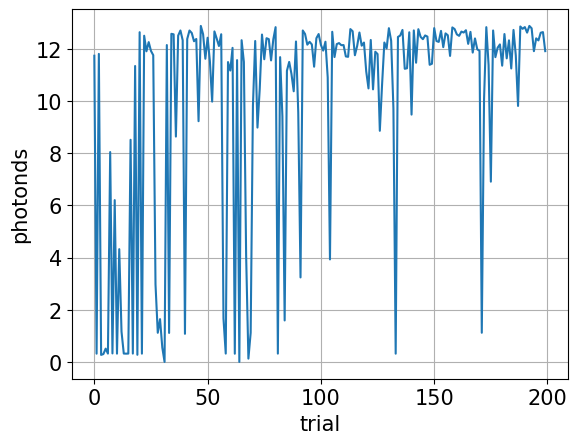

In [33]:
fig, ax = plt.subplots()
ax.plot(df.nphotons)
ax.set_xlabel("trial")
ax.set_ylabel("photonds")
ax.grid()

In [34]:
model = ax_client.generation_strategy.model

In [35]:
render(plot_slice(model, "Ωl0", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "Ωl1", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "ω0", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "ω1", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "φ1", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "ton0", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "ton1", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "toff0", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "toff1", "nphotons", slice_values=best_parameters))
render(plot_slice(model, "phase1", "nphotons", slice_values=best_parameters))


In [36]:
render(
    plot_contour(
        model=model,
        param_x="Ωl0",
        param_y="Ωl1",
        metric_name="nphotons",
        slice_values=best_parameters,
    )
)

In [37]:
render(
    plot_contour(
        model=model,
        param_x="ton0",
        param_y="ton1",
        metric_name="nphotons",
        slice_values=best_parameters,
    )
)

In [38]:
render(
    plot_contour(
        model=model,
        param_x="ω0",
        param_y="ω1",
        metric_name="nphotons",
        slice_values=best_parameters,
    )
)

In [39]:
df_nphotons = df[list(ax_client.experiment.parameters.keys()) + ["nphotons"]]
df_nphotons

Ωl0       Ωl1    phase1        ω0        ω1        φ1       ton0  \
0    0.276696  0.303017  2.599737  0.706389  0.216311  4.742339  16.184564   
1    0.582053  0.209817  5.179127  1.514130  1.201925  0.932422  39.136590   
2    0.399449  0.423447  1.505306  0.482035  1.506493  3.031758   7.679452   
3    0.089647  0.089654  3.331478  1.297569  0.521377  3.908920  26.999306   
4    0.127660  0.491320  5.865981  1.202126  0.848316  5.593678   4.083821   
..        ...       ...       ...       ...       ...       ...        ...   
195  0.331083  0.550031  0.000000  1.203111  0.234114  0.000000  38.065996   
196  0.410747  0.534448  0.206119  1.133288  0.337930  0.000000  33.571982   
197  0.394218  0.550031  1.824837  0.385595  0.870472  0.000000  33.563341   
198  0.262363  0.550031  1.378174  0.960486  0.282614  6.283185  28.712361   
199  0.496635  0.450631  2.178095  0.371345  0.603356  6.283185  27.854913   

         toff0       ton1      toff1   nphotons  
0    22.969751  28.447044  29.158578  11.731459  
1    16.382244  18.092112  18.047765   0.315960  
2     3.538939   8.857969   9.764455  11.801142  
3    37.108912  39.602879  38.653588   0.269093  
4     8.672479   3.519993  14.897544   0.300816  
..         ...        ...        ...        ...  
195   0.000000  26.292579  40.000000  12.396622  
196   0.000000  26.063187  40.000000  12.318786  
197   0.000000  40.000000  30.462267  12.611505  
198   0.000000  35.395936   0.000000  12.636681  
199   0.000000  40.000000  40.000000  11.907664  

[200 rows x 11 columns]

In [40]:
df_path = Path().cwd() / (
    " __ ".join([t.name.replace("'", "").replace("/", "_") for t in trans])
    + "_bayesian.csv"
)
df_nphotons.to_csv(df_path, sep=",", index=False)


# Simulate the best parameters

In [41]:
odepars_opt = copy.copy(odepars)

best_parameters = rescale_parameters(best_parameters)

for key, value in best_parameters.items():
    setattr(odepars_opt, key, value)

In [42]:
# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars_opt, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
    callback=None,
    save_idxs=save_idxs,
)
lindblad_julia.setup_problem(problem.odepars, problem.tspan, problem.ρ, problem.name)

In [43]:
# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars_opt, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
    callback=None,
    save_idxs=save_idxs,
)

In [44]:
lindblad_julia.solve_problem(problem, config)
results = lindblad_julia.OBEResult(
    t=np.array(Main.eval("sol.t")), y=np.array(Main.eval("sol.u[:]")).real.T
)

# photons = 12.7
rate = 4.89e+04 Hz


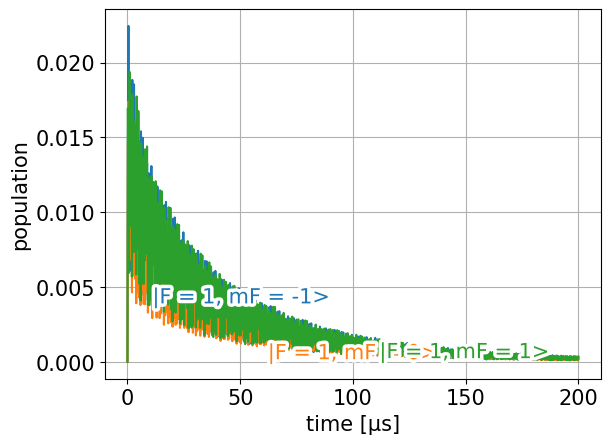

In [45]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} Hz")

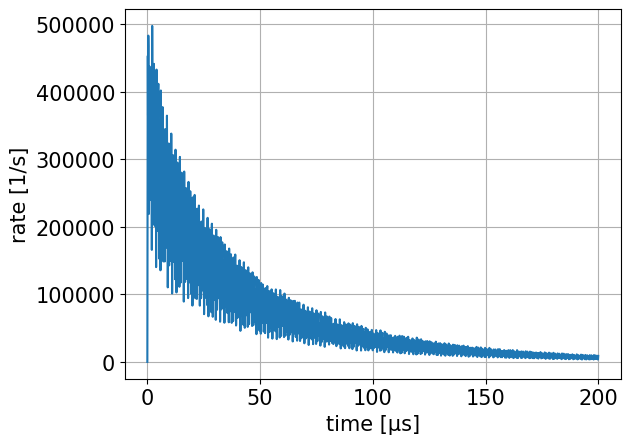

In [46]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].sum(axis=0) * hamiltonian.Γ)

ax.set_xlabel("time [μs]")
ax.set_ylabel("rate [1/s]")

ax.grid()


In [47]:
rate = float(
    (results.y[indices_excited].sum(axis=0) * hamiltonian.Γ)[results.t > 50e-6].mean()
)
print(f"rate = {rate:.2e}/s")

rate = 2.97e+04/s


# photons = 12.7
rate = 4.89e+04 Hz


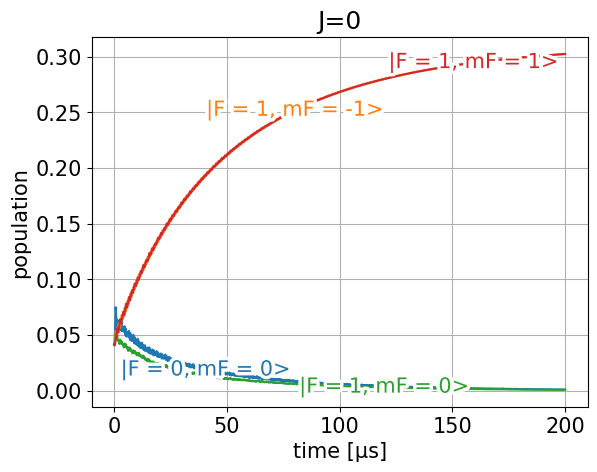

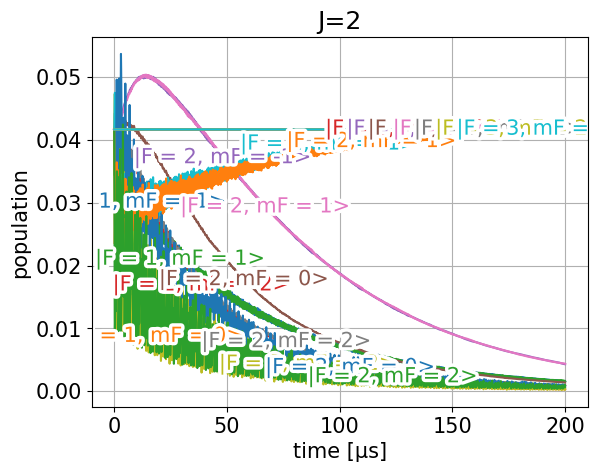

In [48]:
for J, ind in enumerate(
    [indices_J0, indices_J1, indices_J2, indices_J3, indices_J4, indices_J5]
):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} Hz")